In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import models, transforms
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import os
import copy
from myImageFolder import MyImageFolder
import pandas as pd
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve,auc
from PIL import Image, ImageDraw
from ecoc_auc import ecoc_auc
from IPython.display import display

plt.ion()   # interactive mode

In [2]:
def plot_confusion_matrix(cm,idx,labels,cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('confusion matrix')
    plt.colorbar()
    plt.tight_layout()
    plt.xticks(idx, labels, rotation=-90)
    plt.yticks(idx, labels)
    plt.xlabel('True label',rotation='horizontal', ha='right')
    plt.ylabel('Predicted label')
    plt.show()

In [3]:
# Data transformation for testing
data_transforms = transforms.Compose([
        transforms.Resize(255),
        transforms.CenterCrop(224),
        transforms.RandomRotation(10),
        transforms.ColorJitter(0.2,0.2,0.2),
        transforms.RandomAffine(degrees=2, translate=(0.15,0.1),scale=(0.75,1.05)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    ])

data_dir = '/home/kaiyihuang/nexperia/new_data/test'
image_datasets = MyImageFolder(data_dir,data_transforms)
dataloaders = torch.utils.data.DataLoader(image_datasets, batch_size=8,shuffle=True, num_workers=4)
dataset_sizes = len(image_datasets)
class_names = image_datasets.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
image_datasets[0][1]

'/home/kaiyihuang/nexperia/new_data/test/chipping/WEL91416811A_04-APG_ITIS_H13_2_115_3.bmp'

In [30]:
class_names

['chipping',
 'device_flip',
 'empty_pocket',
 'foreign_material',
 'good',
 'lead_defect',
 'lead_glue',
 'marking_defect',
 'pocket_damage',
 'scratch']

In [4]:
# load the trained model
model_dict = torch.load('resnet_18_dict.pt')
model_wts = model_dict['model_state_dict']

In [7]:
ecoc = model_dict['error_correcting_output_code']

In [9]:
model_dict.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'val_acc', 'val_loss', 'best_val_auc_bad', 'val_auc_fm', 'val_fpr_bad', 'val_tpr_bad', 'val_thresholds_bad', 'val_fpr_fm', 'val_tpr_fm', 'val_thresholds_fm', 'error_correcting_output_code'])

In [25]:
tpr_bad = model_dict['val_tpr_bad']
fpr_bad = model_dict['val_fpr_bad']
thr_bad = model_dict['val_thresholds_bad']
a = tpr_bad >= 0.995
np.arange(fpr_bad.shape[0])[a][np.argmin(fpr_bad[a])]

14

In [41]:
tpr_fm = model_dict['val_tpr_fm']
fpr_fm = model_dict['val_fpr_fm']

In [46]:
fpr_bad

array([0.02693848, 0.02730251, 0.02766655, 0.02803058, 0.02803058,
       0.02839461, 0.02839461, 0.02839461, 0.02912268, 0.02912268,
       0.02985075, 0.02985075, 0.03021478, 0.03057881, 0.03094285,
       0.03167091, 0.03239898, 0.03239898, 0.03276301, 0.03312705,
       0.03349108, 0.03385511, 0.03385511, 0.03531125, 0.03603932,
       0.03785948, 0.03785948, 0.03895158, 0.03895158, 0.03967965,
       0.04040772, 0.04113578, 0.04259192, 0.04331999, 0.04404805,
       0.04404805, 0.04477612, 0.04514015, 0.04550419, 0.04550419,
       0.04659629, 0.04732435, 0.04805242, 0.04987259, 0.05096469,
       0.05169276, 0.05205679, 0.05205679, 0.05314889, 0.05314889,
       0.05424099, 0.05496906, 0.05678922, 0.05860939, 0.06006553,
       0.06224973, 0.06370586, 0.06552603, 0.0673462 , 0.0695304 ,
       0.0728067 , 0.07462687, 0.07753913, 0.08081544, 0.0826356 ,
       0.0848198 , 0.08773207, 0.09319257, 0.09610484, 0.10265744,
       0.10666181, 0.11321442, 0.11758282, 0.12377139, 0.13068

In [47]:
np.arange(fpr_bad.shape[0])[fpr_bad<=0.10][np.argmax(fpr_bad[fpr_bad<=0.10])]

68

In [31]:
np.arange(fpr_bad.shape[0])[tpr_bad>=0.9990][np.argmin(tpr_bad[tpr_bad>=0.9990])]

37

In [7]:
ecoc[:,:5]

array([[1., 1., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 1., 0., 0.],
       [1., 1., 0., 1., 1.],
       [1., 0., 0., 0., 1.],
       [0., 1., 0., 1., 1.],
       [0., 1., 1., 1., 1.],
       [1., 0., 0., 1., 1.],
       [1., 1., 0., 0., 1.],
       [0., 1., 1., 0., 0.]])

In [5]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 10.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)

model_ft.load_state_dict(model_wts)

<All keys matched successfully>

In [48]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

model_ft.load_state_dict(model_wts)

<All keys matched successfully>

In [6]:
def perf_measure_bad(y_actual, y_hat):
    TP = torch.mul(y_actual!=4,y_hat!=4).sum().item()
    FP = torch.mul(y_actual==4,y_hat!=4).sum().item()
    TN = torch.mul(y_actual==4,y_hat==4).sum().item()
    FN = torch.mul(y_actual!=4,y_hat==4).sum().item()    

    return (TP, FP, TN, FN)

In [7]:
def perf_measure_fm(y_actual, y_hat):
    TN = torch.mul(y_actual!=3,y_hat!=3).sum().item()
    FN = torch.mul(y_actual==3,y_hat!=3).sum().item()
    TP = torch.mul(y_actual==3,y_hat==3).sum().item()
    FP = torch.mul(y_actual!=3,y_hat==3).sum().item()    

    return (TP, FP, TN, FN)

In [8]:
def good_to_false_fm(y_actual, y_hat):
    f_fm = torch.mul(y_actual==4,y_hat==3).sum().item()
    
    return f_fm

In [8]:
# test resnet 18 with 23 bits ecoc pos weighted
model_ft.eval()
results = pd.DataFrame(columns=['id','label'])

running_corrects = 0
y_true = []
y_pred = []
y_dist_good = []
y_dist_fm = []

for i, ((inputs, labels), names) in enumerate(dataloaders, 0):
    inputs = inputs.to(device)
    labels = labels.to(device)
    codes = torch.tensor(list(map(lambda row: ecoc[row,:], labels))).to(device)

    # forward
    with torch.set_grad_enabled(False):
        outputs = model_ft(inputs)
        probs = torch.sigmoid(outputs)
        
        # decide class by Hamming distance
        fun = lambda code: torch.argmin(torch.norm(code - ecoc,dim=1))
        preds = torch.stack([fun(probs[i,:].detach().cpu()) for i in range(probs.shape[0])])
        fun_good = lambda code: torch.norm(code - ecoc[4,:])
        dists_good = torch.stack([fun_good(probs[i,:].detach().cpu()) for i in range(probs.shape[0])])
        fun_fm = lambda code: torch.norm(code - ecoc[3,:])
        dists_fm = torch.stack([fun_fm(probs[i,:].detach().cpu()) for i in range(probs.shape[0])])
                
    running_corrects += torch.sum(preds == labels.data.cpu())
    
    y_true.append(labels.data.cpu())
    y_pred.append(preds)
    y_dist_good.append(dists_good)
    y_dist_fm.append(dists_fm)
    
    result = pd.DataFrame({'id':names,'label':labels.detach().cpu(),'prediction':preds.detach()})
    result['good_distance'] = dists_good.detach()
    result['fm_distance'] = dists_fm.detach()
    results = results.append(result)

acc = running_corrects.double() / dataset_sizes

y_true = torch.cat(y_true)
y_pred = torch.cat(y_pred)
y_dist_good = torch.cat(y_dist_good)
y_dist_fm = torch.cat(y_dist_fm)

y_bad = y_true!=4
y_fm = y_true==3
y_bad_pred = y_pred!=4
y_bad_dist = np.where(y_pred==4,y_dist_good,0)
y_fm_pred = y_pred==3

fpr_bad,tpr_bad,thresholds_bad = ecoc_auc(y_bad.numpy(), y_bad_pred.numpy(),y_bad_dist,'close')
fpr_fm,tpr_fm,thresholds_fm = ecoc_auc(y_fm.numpy(), y_fm_pred.numpy(),y_dist_fm.numpy(),'far')

auc_bad = auc(np.append(np.linspace(0,fpr_bad[0],num=100),fpr_bad),np.append(np.ones(100)*tpr_bad[0],tpr_bad))
auc_fm = auc(np.append(fpr_fm,np.linspace(fpr_fm[-1],0,num=100)),np.append(tpr_fm,np.ones(100)*tpr_fm[-1]))

print('Test acc: {:.4f} AUC_bad: {:.4f} AUC_fm: {:.4f}'
      .format(acc, auc_bad, auc_fm))

results['label'] = results['label'].apply(lambda i: class_names[i])
results['prediction'] = results['prediction'].astype('int').apply(lambda i: class_names[i])

results.to_csv('test_result_resnet_18_ecoc_17_bits_pos_weighted.csv',index=False)

Test acc: 0.9272 AUC_bad: 0.9971 AUC_fm: 0.9837


In [9]:
thresholds_bad

array([2.20249803, 2.18047305, 2.15844807, 2.13642309, 2.11439811,
       2.09237313, 2.07034815, 2.04832317, 2.02629819, 2.00427321,
       1.98224823, 1.96022325, 1.93819827, 1.91617329, 1.89414831,
       1.87212333, 1.85009835, 1.82807337, 1.80604839, 1.78402341,
       1.76199843, 1.73997345, 1.71794847, 1.69592349, 1.67389851,
       1.65187353, 1.62984855, 1.60782357, 1.58579859, 1.5637736 ,
       1.54174862, 1.51972364, 1.49769866, 1.47567368, 1.4536487 ,
       1.43162372, 1.40959874, 1.38757376, 1.36554878, 1.3435238 ,
       1.32149882, 1.29947384, 1.27744886, 1.25542388, 1.2333989 ,
       1.21137392, 1.18934894, 1.16732396, 1.14529898, 1.123274  ,
       1.10124902, 1.07922404, 1.05719906, 1.03517408, 1.0131491 ,
       0.99112412, 0.96909914, 0.94707416, 0.92504917, 0.90302419,
       0.88099921, 0.85897423, 0.83694925, 0.81492427, 0.79289929,
       0.77087431, 0.74884933, 0.72682435, 0.70479937, 0.68277439,
       0.66074941, 0.63872443, 0.61669945, 0.59467447, 0.57264

In [10]:
fpr_bad

array([0.02326343, 0.02326343, 0.02359109, 0.02359109, 0.02359109,
       0.02391874, 0.02391874, 0.0242464 , 0.0242464 , 0.0249017 ,
       0.0249017 , 0.02522936, 0.02555701, 0.02555701, 0.02588467,
       0.02621232, 0.02686763, 0.02719528, 0.02817824, 0.0285059 ,
       0.02916121, 0.02981651, 0.03014417, 0.03014417, 0.03079948,
       0.03079948, 0.03178244, 0.0327654 , 0.0327654 , 0.03309305,
       0.03374836, 0.03538663, 0.03538663, 0.03669725, 0.03735256,
       0.03768021, 0.03833552, 0.03866317, 0.03866317, 0.03931848,
       0.03931848, 0.0412844 , 0.04259502, 0.04390564, 0.04521625,
       0.04685452, 0.04783748, 0.04849279, 0.0491481 , 0.05045872,
       0.05144168, 0.05275229, 0.05471822, 0.05602883, 0.0570118 ,
       0.05799476, 0.05865007, 0.05930537, 0.0612713 , 0.06258191,
       0.06651376, 0.06847969, 0.07077326, 0.07306684, 0.07568807,
       0.077654  , 0.07994758, 0.08256881, 0.08650066, 0.08912189,
       0.09174312, 0.09501966, 0.09862385, 0.10157274, 0.10386

In [11]:
tpr_bad

array([0.97686375, 0.97686375, 0.97686375, 0.97686375, 0.97686375,
       0.9781491 , 0.9781491 , 0.9781491 , 0.9781491 , 0.9781491 ,
       0.9781491 , 0.9781491 , 0.9781491 , 0.9781491 , 0.9781491 ,
       0.9781491 , 0.9781491 , 0.9781491 , 0.9781491 , 0.97943445,
       0.97943445, 0.97943445, 0.97943445, 0.97943445, 0.97943445,
       0.98071979, 0.98071979, 0.98071979, 0.98329049, 0.98329049,
       0.98457584, 0.98457584, 0.98457584, 0.98457584, 0.98457584,
       0.98457584, 0.98457584, 0.98457584, 0.98457584, 0.98457584,
       0.98457584, 0.98457584, 0.98457584, 0.98457584, 0.98457584,
       0.98457584, 0.98586118, 0.98586118, 0.98586118, 0.98586118,
       0.98586118, 0.98586118, 0.98586118, 0.98586118, 0.98714653,
       0.98714653, 0.98714653, 0.98843188, 0.99100257, 0.99100257,
       0.99100257, 0.99100257, 0.99100257, 0.99100257, 0.99228792,
       0.99228792, 0.99228792, 0.99228792, 0.99228792, 0.99228792,
       0.99228792, 0.99228792, 0.99228792, 0.99357326, 0.99357

In [128]:
# test resnet 18 with 17 bits ecoc pos weighted
model_ft.eval()
results = pd.DataFrame(columns=['id','label'])

running_corrects = 0
y_true = []
y_pred = []
y_dist_good = []
y_dist_fm = []

for i, ((inputs, labels), names) in enumerate(dataloaders, 0):
    inputs = inputs.to(device)
    labels = labels.to(device)
    codes = torch.tensor(list(map(lambda row: ecoc[row,:], labels))).to(device)

    # forward
    with torch.set_grad_enabled(False):
        outputs = model_ft(inputs)
        probs = torch.sigmoid(outputs)
        
        # decide class by Hamming distance
        fun = lambda code: torch.argmin(torch.norm(code - ecoc,dim=1))
        preds = torch.stack([fun(probs[i,:].detach().cpu()) for i in range(probs.shape[0])])
        fun_good = lambda code: torch.norm(code - ecoc[4,:])
        dists_good = torch.stack([fun_good(probs[i,:].detach().cpu()) for i in range(probs.shape[0])])
        fun_fm = lambda code: torch.norm(code - ecoc[3,:])
        dists_fm = torch.stack([fun_fm(probs[i,:].detach().cpu()) for i in range(probs.shape[0])])
                
    running_corrects += torch.sum(preds == labels.data.cpu())
    
    y_true.append(labels.data.cpu())
    y_pred.append(preds)
    y_dist_good.append(dists_good)
    y_dist_fm.append(dists_fm)
    
    result = pd.DataFrame({'id':names,'label':labels.detach().cpu(),'prediction':preds.detach()})
    result['good_distance'] = dists_good.detach()
    result['fm_distance'] = dists_fm.detach()
    results = results.append(result)

acc = running_corrects.double() / dataset_sizes

y_true = torch.cat(y_true)
y_pred = torch.cat(y_pred)
y_dist_good = torch.cat(y_dist_good)
y_dist_fm = torch.cat(y_dist_fm)

y_bad = y_true!=4
y_fm = y_true==3
y_bad_pred = y_pred!=4
y_bad_dist = np.where(y_pred==4,y_dist_good,0)
y_fm_pred = y_pred==3

fpr_bad,tpr_bad,thresholds_bad = ecoc_auc(y_bad.numpy(), y_bad_pred.numpy(),y_bad_dist,'close')
fpr_fm,tpr_fm,thresholds_fm = ecoc_auc(y_fm.numpy(), y_fm_pred.numpy(),y_dist_fm.numpy(),'far')

auc_bad = auc(np.append(np.linspace(0,fpr_bad[0],num=100),fpr_bad),np.append(np.ones(100)*tpr_bad[0],tpr_bad))
auc_fm = auc(np.append(fpr_fm,np.linspace(fpr_fm[-1],0,num=100)),np.append(tpr_fm,np.ones(100)*tpr_fm[-1]))

print('Test acc: {:.4f} AUC_bad: {:.4f} AUC_fm: {:.4f}'
      .format(acc, auc_bad, auc_fm))

results['label'] = results['label'].apply(lambda i: class_names[i])
results['prediction'] = results['prediction'].astype('int').apply(lambda i: class_names[i])

results.to_csv('test_result_resnet_18_ecoc_17_bits_pos_weighted.csv',index=False)

Test acc: 0.9379 AUC_bad: 0.9966 AUC_fm: 0.9872


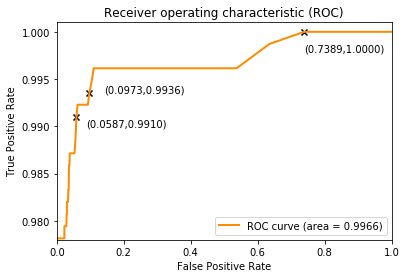

In [138]:
plt.figure()
lw = 2
plt.plot(np.append(np.linspace(0,fpr_bad[0],num=100),fpr_bad),np.append(np.ones(100)*tpr_bad[0],tpr_bad),
         color='darkorange', lw=lw, label='ROC curve (area = %0.4f)' % auc_bad)
plt.scatter(fpr_bad[-7],tpr_bad[-7],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_bad[-7],tpr_bad[-7]), # this is the text
                 (fpr_bad[-7],tpr_bad[-7]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='left')# horizontal alignment can be left, right or center
plt.scatter(fpr_bad[-24],tpr_bad[-24],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_bad[-24],tpr_bad[-24]), # this is the text
                 (fpr_bad[-24],tpr_bad[-24]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(15,0), # distance from text to points (x,y)
                 ha='left',) # horizontal alignment can be left, right or center
plt.scatter(fpr_bad[-34],tpr_bad[-34],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_bad[-34],tpr_bad[-34]), # this is the text
                 (fpr_bad[-34],tpr_bad[-34]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,-10), # distance from text to points (x,y)
                 ha='left')# horizontal alignment can be left, right or center


plt.xlim([0, 1])
plt.ylim([0.978, 1.001])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('resnet_18_ecoc_17_bits_pos_weighted_roc.jpg')
plt.show()

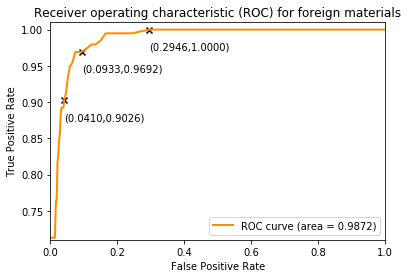

In [134]:
plt.figure()
lw = 2
plt.plot(np.append(fpr_fm,np.linspace(fpr_fm[-1],0,num=100)),np.append(tpr_fm,np.ones(100)*tpr_fm[-1]),
         color='darkorange', lw=lw, label='ROC curve (area = %0.4f)' % auc_fm)
plt.scatter(fpr_fm[15],tpr_fm[15],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_fm[15],tpr_fm[15]), # this is the text
                 (fpr_fm[15],tpr_fm[15]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='left')# horizontal alignment can be left, right or center
plt.scatter(fpr_fm[31],tpr_fm[31],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_fm[31],tpr_fm[31]), # this is the text
                 (fpr_fm[31],tpr_fm[31]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='left',) # horizontal alignment can be left, right or center
plt.scatter(fpr_fm[25],tpr_fm[25],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_fm[25],tpr_fm[25]), # this is the text
                 (fpr_fm[25],tpr_fm[25]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='left')# horizontal alignment can be left, right or center


plt.xlim([0, 1])
plt.ylim([0.71, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) for foreign materials')
plt.legend(loc="lower right")
plt.savefig('resnet_18_ecoc_17_bits_pos_weighted_fm_roc.jpg')
plt.show()

In [154]:
# test resnet 18 with 5 bits ecoc pos weighted
model_ft.eval()
results = pd.DataFrame(columns=['id','label'])

running_corrects = 0
y_true = []
y_pred = []
y_dist_good = []
y_dist_fm = []

for i, ((inputs, labels), names) in enumerate(dataloaders, 0):
    inputs = inputs.to(device)
    labels = labels.to(device)
    codes = torch.tensor(list(map(lambda row: ecoc[row,:], labels))).to(device)

    # forward
    with torch.set_grad_enabled(False):
        outputs = model_ft(inputs)
        probs = torch.sigmoid(outputs)
        
        # decide class by Hamming distance
        fun = lambda code: torch.argmin(torch.norm(code - ecoc,dim=1))
        preds = torch.stack([fun(probs[i,:].detach().cpu()) for i in range(probs.shape[0])])
        fun_good = lambda code: torch.norm(code - ecoc[4,:])
        dists_good = torch.stack([fun_good(probs[i,:].detach().cpu()) for i in range(probs.shape[0])])
        fun_fm = lambda code: torch.norm(code - ecoc[3,:])
        dists_fm = torch.stack([fun_fm(probs[i,:].detach().cpu()) for i in range(probs.shape[0])])
                
    running_corrects += torch.sum(preds == labels.data.cpu())
    
    y_true.append(labels.data.cpu())
    y_pred.append(preds)
    y_dist_good.append(dists_good)
    y_dist_fm.append(dists_fm)
    
    result = pd.DataFrame({'id':names,'label':labels.detach().cpu(),'prediction':preds.detach()})
    result['good_distance'] = dists_good.detach()
    result['fm_distance'] = dists_fm.detach()
    results = results.append(result)

acc = running_corrects.double() / dataset_sizes

y_true = torch.cat(y_true)
y_pred = torch.cat(y_pred)
y_dist_good = torch.cat(y_dist_good)
y_dist_fm = torch.cat(y_dist_fm)

y_bad = y_true!=4
y_fm = y_true==3
y_bad_pred = y_pred!=4
y_bad_dist = np.where(y_pred==4,y_dist_good,0)
y_fm_pred = y_pred==3

fpr_bad,tpr_bad,thresholds_bad = ecoc_auc(y_bad.numpy(), y_bad_pred.numpy(),y_bad_dist,'close')
fpr_fm,tpr_fm,thresholds_fm = ecoc_auc(y_fm.numpy(), y_fm_pred.numpy(),y_dist_fm.numpy(),'far')

auc_bad = auc(np.append(np.linspace(0,fpr_bad[0],num=100),fpr_bad),np.append(np.ones(100)*tpr_bad[0],tpr_bad))
auc_fm = auc(np.append(fpr_fm,np.linspace(fpr_fm[-1],0,num=100)),np.append(tpr_fm,np.ones(100)*tpr_fm[-1]))

print('Test acc: {:.4f} AUC_bad: {:.4f} AUC_fm: {:.4f}'
      .format(acc, auc_bad, auc_fm))

results['label'] = results['label'].apply(lambda i: class_names[i])
results['prediction'] = results['prediction'].astype('int').apply(lambda i: class_names[i])

results.to_csv('test_result_resnet_18_ecoc_5_bits_pos_weighted.csv',index=False)

Test acc: 0.8629 AUC_bad: 0.9928 AUC_fm: 0.8484


In [161]:
thresholds_fm

array([1.95268956, 1.93316267, 1.91363577, 1.89410888, 1.87458198,
       1.85505508, 1.83552819, 1.81600129, 1.7964744 , 1.7769475 ,
       1.75742061, 1.73789371, 1.71836682, 1.69883992, 1.67931302,
       1.65978613, 1.64025923, 1.62073234, 1.60120544, 1.58167855,
       1.56215165, 1.54262475, 1.52309786, 1.50357096, 1.48404407,
       1.46451717, 1.44499028, 1.42546338, 1.40593649, 1.38640959,
       1.36688269, 1.3473558 , 1.3278289 , 1.30830201, 1.28877511,
       1.26924822, 1.24972132, 1.23019442, 1.21066753, 1.19114063,
       1.17161374, 1.15208684, 1.13255995, 1.11303305, 1.09350616,
       1.07397926, 1.05445236, 1.03492547, 1.01539857, 0.99587168,
       0.97634478, 0.95681789, 0.93729099, 0.91776409, 0.8982372 ,
       0.8787103 , 0.85918341, 0.83965651, 0.82012962, 0.80060272,
       0.78107583, 0.76154893, 0.74202203, 0.72249514, 0.70296824,
       0.68344135, 0.66391445, 0.64438756, 0.62486066, 0.60533376,
       0.58580687, 0.56627997, 0.54675308, 0.52722618, 0.50769

In [162]:
fpr_fm

array([1.        , 0.99917469, 0.99917469, 0.99504814, 0.99174691,
       0.98514443, 0.97799175, 0.96808803, 0.95900963, 0.95075653,
       0.94470426, 0.93810179, 0.93314993, 0.92462173, 0.91636864,
       0.90784044, 0.90068776, 0.89436039, 0.88830812, 0.88225585,
       0.8784044 , 0.87180193, 0.86850069, 0.86492435, 0.8605227 ,
       0.85474553, 0.85061898, 0.8434663 , 0.64236589, 0.36643741,
       0.25722146, 0.19477304, 0.15185695, 0.12819807, 0.10729023,
       0.09408528, 0.08033012, 0.07152682, 0.06327373, 0.05722146,
       0.05144429, 0.04704264, 0.04236589, 0.03796424, 0.03411279,
       0.03053645, 0.02778542, 0.02503439, 0.02310867, 0.02090784,
       0.01898212, 0.0173315 , 0.01595598, 0.01513067, 0.01375516,
       0.01348006, 0.01292985, 0.01265475, 0.01210454, 0.01127923,
       0.01127923, 0.01127923, 0.01127923, 0.01127923, 0.01127923,
       0.01127923, 0.01127923, 0.01127923, 0.01127923, 0.01127923,
       0.01127923, 0.01127923, 0.01127923, 0.01127923, 0.01127

In [163]:
tpr_fm

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.99487179, 0.99487179,
       0.97948718, 0.97435897, 0.96923077, 0.96923077, 0.96923077,
       0.95897436, 0.94358974, 0.93333333, 0.91794872, 0.91282051,
       0.90769231, 0.88205128, 0.87692308, 0.86153846, 0.84102564,
       0.83076923, 0.81025641, 0.8       , 0.78974359, 0.77948718,
       0.77435897, 0.76410256, 0.75384615, 0.75384615, 0.74871795,
       0.73846154, 0.73846154, 0.7025641 , 0.7025641 , 0.68205128,
       0.66153846, 0.64615385, 0.63076923, 0.62564103, 0.62051282,
       0.61025641, 0.60512821, 0.57948718, 0.56923077, 0.56410256,
       0.52820513, 0.4974359 , 0.48205128, 0.45128205, 0.44102564,
       0.44102564, 0.44102564, 0.44102564, 0.44102564, 0.44102564,
       0.44102564, 0.44102564, 0.44102564, 0.44102564, 0.44102564,
       0.44102564, 0.44102564, 0.44102564, 0.44102564, 0.44102

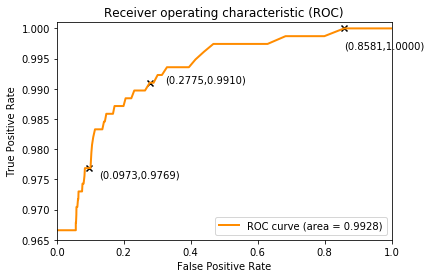

In [160]:
plt.figure()
lw = 2
plt.plot(np.append(np.linspace(0,fpr_bad[0],num=100),fpr_bad),np.append(np.ones(100)*tpr_bad[0],tpr_bad),
         color='darkorange', lw=lw, label='ROC curve (area = %0.4f)' % auc_bad)
plt.scatter(fpr_bad[-5],tpr_bad[-5],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_bad[-5],tpr_bad[-5]), # this is the text
                 (fpr_bad[-5],tpr_bad[-5]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='left')# horizontal alignment can be left, right or center
plt.scatter(fpr_bad[-25],tpr_bad[-25],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_bad[-25],tpr_bad[-25]), # this is the text
                 (fpr_bad[-25],tpr_bad[-25]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(15,0), # distance from text to points (x,y)
                 ha='left',) # horizontal alignment can be left, right or center
plt.scatter(fpr_bad[-58],tpr_bad[-58],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_bad[-58],tpr_bad[-58]), # this is the text
                 (fpr_bad[-58],tpr_bad[-58]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,-10), # distance from text to points (x,y)
                 ha='left')# horizontal alignment can be left, right or center


plt.xlim([0, 1])
plt.ylim([0.965, 1.001])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('resnet_18_ecoc_5_bits_pos_weighted_roc.jpg')
plt.show()

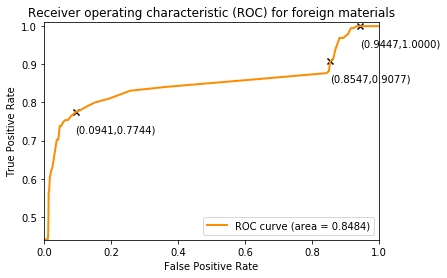

In [164]:
plt.figure()
lw = 2
plt.plot(np.append(fpr_fm,np.linspace(fpr_fm[-1],0,num=100)),np.append(tpr_fm,np.ones(100)*tpr_fm[-1]),
         color='darkorange', lw=lw, label='ROC curve (area = %0.4f)' % auc_fm)
plt.scatter(fpr_fm[10],tpr_fm[10],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_fm[10],tpr_fm[10]), # this is the text
                 (fpr_fm[10],tpr_fm[10]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='left')# horizontal alignment can be left, right or center
plt.scatter(fpr_fm[35],tpr_fm[35],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_fm[35],tpr_fm[35]), # this is the text
                 (fpr_fm[35],tpr_fm[35]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='left',) # horizontal alignment can be left, right or center
plt.scatter(fpr_fm[25],tpr_fm[25],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_fm[25],tpr_fm[25]), # this is the text
                 (fpr_fm[25],tpr_fm[25]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='left')# horizontal alignment can be left, right or center


plt.xlim([0, 1])
plt.ylim([0.44, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) for foreign materials')
plt.legend(loc="lower right")
plt.savefig('resnet_18_ecoc_5_bits_pos_weighted_fm_roc.jpg')
plt.show()

In [109]:
# test resnet 18 with 29 bits ecoc pos weighted
model_ft.eval()
results = pd.DataFrame(columns=['id','label'])

running_corrects = 0
y_true = []
y_pred = []
y_dist_good = []
y_dist_fm = []

for i, ((inputs, labels), names) in enumerate(dataloaders, 0):
    inputs = inputs.to(device)
    labels = labels.to(device)
    codes = torch.tensor(list(map(lambda row: ecoc[row,:], labels))).to(device)

    # forward
    with torch.set_grad_enabled(False):
        outputs = model_ft(inputs)
        probs = torch.sigmoid(outputs)
        
        # decide class by Hamming distance
        fun = lambda code: torch.argmin(torch.norm(code - ecoc,dim=1))
        preds = torch.stack([fun(probs[i,:].detach().cpu()) for i in range(probs.shape[0])])
        fun_good = lambda code: torch.norm(code - ecoc[4,:])
        dists_good = torch.stack([fun_good(probs[i,:].detach().cpu()) for i in range(probs.shape[0])])
        fun_fm = lambda code: torch.norm(code - ecoc[3,:])
        dists_fm = torch.stack([fun_fm(probs[i,:].detach().cpu()) for i in range(probs.shape[0])])
                
    running_corrects += torch.sum(preds == labels.data.cpu())
    
    y_true.append(labels.data.cpu())
    y_pred.append(preds)
    y_dist_good.append(dists_good)
    y_dist_fm.append(dists_fm)
    
    result = pd.DataFrame({'id':names,'label':labels.detach().cpu(),'prediction':preds.detach()})
    result['good_distance'] = dists_good.detach()
    result['fm_distance'] = dists_fm.detach()
    results = results.append(result)

acc = running_corrects.double() / dataset_sizes

y_true = torch.cat(y_true)
y_pred = torch.cat(y_pred)
y_dist_good = torch.cat(y_dist_good)
y_dist_fm = torch.cat(y_dist_fm)

y_bad = y_true!=4
y_fm = y_true==3
y_bad_pred = y_pred!=4
y_bad_dist = np.where(y_pred==4,y_dist_good,0)
y_fm_pred = y_pred==3

fpr_bad,tpr_bad,thresholds_bad = ecoc_auc(y_bad.numpy(), y_bad_pred.numpy(),y_bad_dist,'close')
fpr_fm,tpr_fm,thresholds_fm = ecoc_auc(y_fm.numpy(), y_fm_pred.numpy(),y_dist_fm.numpy(),'far')

auc_bad = auc(np.append(np.linspace(0,fpr_bad[0],num=100),fpr_bad),np.append(np.ones(100)*tpr_bad[0],tpr_bad))
auc_fm = auc(np.append(fpr_fm,np.linspace(fpr_fm[-1],0,num=100)),np.append(tpr_fm,np.ones(100)*tpr_fm[-1]))

print('Test acc: {:.4f} AUC_bad: {:.4f} AUC_fm: {:.4f}'
      .format(acc, auc_bad, auc_fm))

results['label'] = results['label'].apply(lambda i: class_names[i])
results['prediction'] = results['prediction'].astype('int').apply(lambda i: class_names[i])

results.to_csv('test_result_resnet_18_ecoc_29_bits_pos_weighted.csv',index=False)

Test acc: 0.9535 AUC_bad: 0.9967 AUC_fm: 0.9672


In [115]:
thresholds_fm

array([4.04525901, 4.00480642, 3.96435383, 3.92390124, 3.88344865,
       3.84299606, 3.80254347, 3.76209088, 3.72163829, 3.6811857 ,
       3.64073311, 3.60028052, 3.55982793, 3.51937534, 3.47892275,
       3.43847016, 3.39801757, 3.35756498, 3.31711239, 3.2766598 ,
       3.23620721, 3.19575462, 3.15530203, 3.11484944, 3.07439685,
       3.03394426, 2.99349167, 2.95303908, 2.91258649, 2.8721339 ,
       2.83168131, 2.79122872, 2.75077613, 2.71032354, 2.66987095,
       2.62941836, 2.58896577, 2.54851318, 2.50806059, 2.467608  ,
       2.42715541, 2.38670282, 2.34625023, 2.30579764, 2.26534505,
       2.22489246, 2.18443987, 2.14398728, 2.10353469, 2.0630821 ,
       2.02262951, 1.98217692, 1.94172433, 1.90127174, 1.86081915,
       1.82036656, 1.77991397, 1.73946138, 1.69900879, 1.6585562 ,
       1.6181036 , 1.57765101, 1.53719842, 1.49674583, 1.45629324,
       1.41584065, 1.37538806, 1.33493547, 1.29448288, 1.25403029,
       1.2135777 , 1.17312511, 1.13267252, 1.09221993, 1.05176

In [116]:
fpr_fm

array([1.        , 0.99779917, 0.99642366, 0.99339752, 0.9911967 ,
       0.98817056, 0.98762036, 0.98569464, 0.97964237, 0.97193948,
       0.95598349, 0.94415406, 0.9301238 , 0.91884457, 0.90949106,
       0.49848693, 0.23631362, 0.16698762, 0.13314993, 0.10756534,
       0.09078404, 0.07977992, 0.07070151, 0.06354883, 0.05749656,
       0.05337001, 0.04896836, 0.0434663 , 0.03988996, 0.03576341,
       0.034663  , 0.03081155, 0.02861073, 0.0261348 , 0.02448418,
       0.02283356, 0.02255846, 0.02090784, 0.01980743, 0.01953232,
       0.01870702, 0.01815681, 0.01678129, 0.01678129, 0.01650619,
       0.01623109, 0.01568088, 0.01485557, 0.01430536, 0.01403026,
       0.01348006, 0.01320495, 0.01320495, 0.01320495, 0.01320495,
       0.01320495, 0.01320495, 0.01320495, 0.01320495, 0.01320495,
       0.01320495, 0.01320495, 0.01320495, 0.01320495, 0.01320495,
       0.01320495, 0.01320495, 0.01320495, 0.01320495, 0.01320495,
       0.01320495, 0.01320495, 0.01320495, 0.01320495, 0.01320

In [117]:
tpr_fm

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.99487179,
       0.99487179, 0.98974359, 0.98461538, 0.98461538, 0.97948718,
       0.97435897, 0.96923077, 0.96923077, 0.95384615, 0.95384615,
       0.94358974, 0.94358974, 0.93333333, 0.91282051, 0.90769231,
       0.90769231, 0.89230769, 0.89230769, 0.88205128, 0.87692308,
       0.87179487, 0.86666667, 0.86153846, 0.85641026, 0.85641026,
       0.85641026, 0.85641026, 0.85128205, 0.85128205, 0.85128205,
       0.85128205, 0.85128205, 0.85128205, 0.85128205, 0.85128205,
       0.85128205, 0.85128205, 0.85128205, 0.85128205, 0.85128205,
       0.85128205, 0.85128205, 0.85128205, 0.85128205, 0.85128205,
       0.85128205, 0.85128205, 0.85128205, 0.85128205, 0.85128205,
       0.85128205, 0.85128205, 0.85128205, 0.85128205, 0.85128205,
       0.85128205, 0.85128205, 0.85128205, 0.85128205, 0.85128205,
       0.85128205, 0.85128205, 0.85128205, 0.85128205, 0.85128

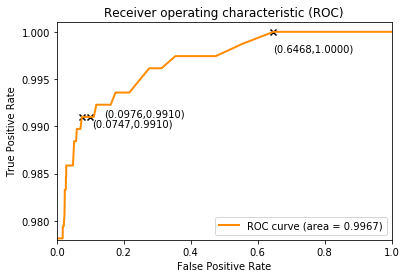

In [114]:
plt.figure()
lw = 2
plt.plot(np.append(np.linspace(0,fpr_bad[0],num=100),fpr_bad),np.append(np.ones(100)*tpr_bad[0],tpr_bad),
         color='darkorange', lw=lw, label='ROC curve (area = %0.4f)' % auc_bad)
plt.scatter(fpr_bad[-7],tpr_bad[-7],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_bad[-7],tpr_bad[-7]), # this is the text
                 (fpr_bad[-7],tpr_bad[-7]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='left')# horizontal alignment can be left, right or center
plt.scatter(fpr_bad[-26],tpr_bad[-26],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_bad[-26],tpr_bad[-26]), # this is the text
                 (fpr_bad[-26],tpr_bad[-26]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(15,0), # distance from text to points (x,y)
                 ha='left',) # horizontal alignment can be left, right or center
plt.scatter(fpr_bad[-31],tpr_bad[-31],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_bad[-31],tpr_bad[-31]), # this is the text
                 (fpr_bad[-31],tpr_bad[-31]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,-10), # distance from text to points (x,y)
                 ha='left')# horizontal alignment can be left, right or center


plt.xlim([0, 1])
plt.ylim([0.978, 1.001])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('resnet_18_ecoc_29_bits_pos_weighted_roc.jpg')
plt.show()

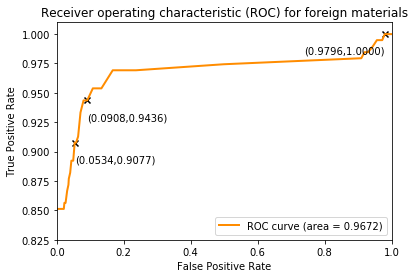

In [119]:
plt.figure()
lw = 2
plt.plot(np.append(fpr_fm,np.linspace(fpr_fm[-1],0,num=100)),np.append(tpr_fm,np.ones(100)*tpr_fm[-1]),
         color='darkorange', lw=lw, label='ROC curve (area = %0.4f)' % auc_fm)
plt.scatter(fpr_fm[8],tpr_fm[8],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_fm[8],tpr_fm[8]), # this is the text
                 (fpr_fm[8],tpr_fm[8]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='right')# horizontal alignment can be left, right or center
plt.scatter(fpr_fm[20],tpr_fm[20],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_fm[20],tpr_fm[20]), # this is the text
                 (fpr_fm[20],tpr_fm[20]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='left',) # horizontal alignment can be left, right or center
plt.scatter(fpr_fm[25],tpr_fm[25],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_fm[25],tpr_fm[25]), # this is the text
                 (fpr_fm[25],tpr_fm[25]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='left')# horizontal alignment can be left, right or center


plt.xlim([0, 1])
plt.ylim([0.825, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) for foreign materials')
plt.legend(loc="lower right")
plt.savefig('resnet_18_ecoc_29_bits_pos_weighted_fm_roc.jpg')
plt.show()

In [68]:
# test resnet 18 with 40 bits ecoc pos weighted
model_ft.eval()
results = pd.DataFrame(columns=['id','label'])

running_corrects = 0
y_true = []
y_pred = []
y_dist_good = []
y_dist_fm = []

for i, ((inputs, labels), names) in enumerate(dataloaders, 0):
    inputs = inputs.to(device)
    labels = labels.to(device)
    codes = torch.tensor(list(map(lambda row: ecoc[row,:], labels))).to(device)

    # forward
    with torch.set_grad_enabled(False):
        outputs = model_ft(inputs)
        probs = torch.sigmoid(outputs)
        
        # decide class by Hamming distance
        fun = lambda code: torch.argmin(torch.norm(code - ecoc,dim=1))
        preds = torch.stack([fun(probs[i,:].detach().cpu()) for i in range(probs.shape[0])])
        fun_good = lambda code: torch.norm(code - ecoc[4,:])
        dists_good = torch.stack([fun_good(probs[i,:].detach().cpu()) for i in range(probs.shape[0])])
        fun_fm = lambda code: torch.norm(code - ecoc[3,:])
        dists_fm = torch.stack([fun_fm(probs[i,:].detach().cpu()) for i in range(probs.shape[0])])
                
    running_corrects += torch.sum(preds == labels.data.cpu())
    
    y_true.append(labels.data.cpu())
    y_pred.append(preds)
    y_dist_good.append(dists_good)
    y_dist_fm.append(dists_fm)
    
    result = pd.DataFrame({'id':names,'label':labels.detach().cpu(),'prediction':preds.detach()})
    result['good_distance'] = dists_good.detach()
    result['fm_distance'] = dists_fm.detach()
    results = results.append(result)

acc = running_corrects.double() / dataset_sizes

y_true = torch.cat(y_true)
y_pred = torch.cat(y_pred)
y_dist_good = torch.cat(y_dist_good)
y_dist_fm = torch.cat(y_dist_fm)

y_bad = y_true!=4
y_fm = y_true==3
y_bad_pred = y_pred!=4
y_bad_dist = np.where(y_pred==4,y_dist_good,0)
y_fm_pred = y_pred==3

fpr_bad,tpr_bad,thresholds_bad = ecoc_auc(y_bad.numpy(), y_bad_pred.numpy(),y_bad_dist,'close')
fpr_fm,tpr_fm,thresholds_fm = ecoc_auc(y_fm.numpy(), y_fm_pred.numpy(),y_dist_fm.numpy(),'far')

auc_bad = auc(np.append(np.linspace(0,fpr_bad[0],num=100),fpr_bad),np.append(np.ones(100)*tpr_bad[0],tpr_bad))
auc_fm = auc(np.append(fpr_fm,np.linspace(fpr_fm[-1],0,num=100)),np.append(tpr_fm,np.ones(100)*tpr_fm[-1]))

print('Test acc: {:.4f} AUC_bad: {:.4f} AUC_fm: {:.4f}'
      .format(acc, auc_bad, auc_fm))

results['label'] = results['label'].apply(lambda i: class_names[i])
results['prediction'] = results['prediction'].astype('int').apply(lambda i: class_names[i])

results.to_csv('test_result_resnet_18_ecoc_40_bits_pos_weighted.csv',index=False)

Test acc: 0.9366 AUC_bad: 0.9971 AUC_fm: 0.9865


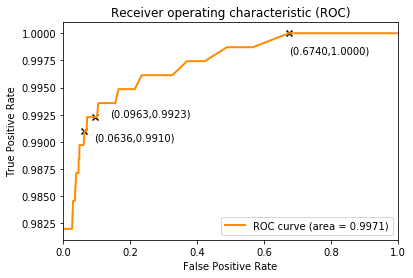

In [77]:
plt.figure()
lw = 2
plt.plot(np.append(np.linspace(0,fpr_bad[0],num=100),fpr_bad),np.append(np.ones(100)*tpr_bad[0],tpr_bad),
         color='darkorange', lw=lw, label='ROC curve (area = %0.4f)' % auc_bad)
plt.scatter(fpr_bad[-11],tpr_bad[-11],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_bad[-11],tpr_bad[-11]), # this is the text
                 (fpr_bad[-11],tpr_bad[-11]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='left')# horizontal alignment can be left, right or center
plt.scatter(fpr_bad[-34],tpr_bad[-34],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_bad[-34],tpr_bad[-34]), # this is the text
                 (fpr_bad[-34],tpr_bad[-34]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(15,0), # distance from text to points (x,y)
                 ha='left',) # horizontal alignment can be left, right or center
plt.scatter(fpr_bad[-47],tpr_bad[-47],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_bad[-47],tpr_bad[-47]), # this is the text
                 (fpr_bad[-47],tpr_bad[-47]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,-10), # distance from text to points (x,y)
                 ha='left')# horizontal alignment can be left, right or center


plt.xlim([0, 1])
plt.ylim([0.981, 1.001])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('resnet_18_ecoc_40_bits_pos_weighted_roc.jpg')
plt.show()

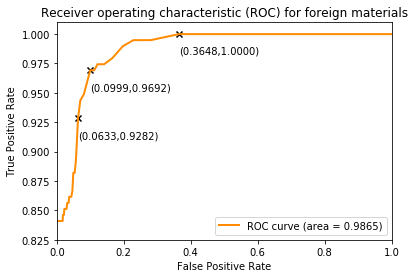

In [79]:
plt.figure()
lw = 2
plt.plot(np.append(fpr_fm,np.linspace(fpr_fm[-1],0,num=100)),np.append(tpr_fm,np.ones(100)*tpr_fm[-1]),
         color='darkorange', lw=lw, label='ROC curve (area = %0.4f)' % auc_fm)
plt.scatter(fpr_fm[9],tpr_fm[9],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_fm[9],tpr_fm[9]), # this is the text
                 (fpr_fm[9],tpr_fm[9]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='left')# horizontal alignment can be left, right or center
plt.scatter(fpr_fm[17],tpr_fm[17],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_fm[17],tpr_fm[17]), # this is the text
                 (fpr_fm[17],tpr_fm[17]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='left',) # horizontal alignment can be left, right or center
plt.scatter(fpr_fm[21],tpr_fm[21],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_fm[21],tpr_fm[21]), # this is the text
                 (fpr_fm[21],tpr_fm[21]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='left')# horizontal alignment can be left, right or center


plt.xlim([0, 1])
plt.ylim([0.825, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) for foreign materials')
plt.legend(loc="lower right")
plt.savefig('resnet_18_ecoc_40_bits_pos_weighted_fm_roc.jpg')
plt.show()

[[2978    3    1    0    3    5    0    0    0    2]
 [  29  351    2    0   14    1    0    3    0   27]
 [   0    0    6    0    0    0    0    0    0    0]
 [   0    0    3   20    0    2    0    1    0    0]
 [  29    4    1    0  164    2    0    1    1   24]
 [   0    0    0    0    0    0    0    0    0    0]
 [   2    2    1    0    3   12   62    6    0    1]
 [   2    0    0    0    0    0    0    2    0    0]
 [   1    8    0    0    8    2    0    5    0   17]
 [  11    0    0    0    3    1    0    0    0    4]]


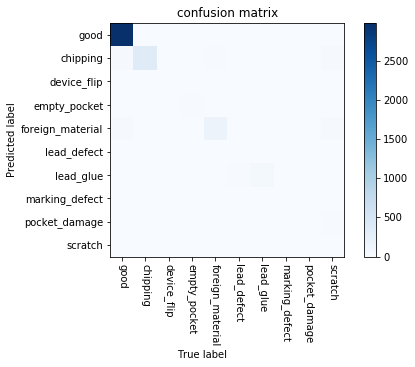

In [83]:
# confusion matrix
cm = confusion_matrix(results.label.to_numpy(), results.prediction.to_numpy())
idx = [4,0,1,2,3,5,6,7,8,9]
cm = cm[:,idx]
cm = cm[idx,:]
print(cm.T)
plot_confusion_matrix(cm.T,range(10),[class_names[i] for i in idx])

[[ 764   14]
 [  74 2978]]


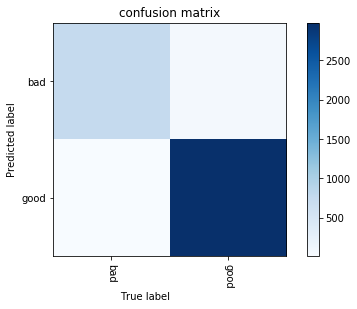

In [84]:
cm_2 = np.array([[cm[0,0], np.sum(cm[0,1:])],
                 [np.sum(cm[1:,0]), np.sum(cm[1:,1:])]])
idx_2 = [1,0]
cm_2 = cm_2[:,idx_2]
cm_2 = cm_2[idx_2,:]
print(cm_2)
plot_confusion_matrix(cm_2.T,[0,1],['bad', 'good'])

In [92]:
# test resnet 18 with 35 bits ecoc pos weighted
model_ft.eval()
results = pd.DataFrame(columns=['id','label'])

running_corrects = 0
y_true = []
y_pred = []
y_dist_good = []
y_dist_fm = []

for i, ((inputs, labels), names) in enumerate(dataloaders, 0):
    inputs = inputs.to(device)
    labels = labels.to(device)
    codes = torch.tensor(list(map(lambda row: ecoc[row,:], labels))).to(device)

    # forward
    with torch.set_grad_enabled(False):
        outputs = model_ft(inputs)
        probs = torch.sigmoid(outputs)
        
        # decide class by Hamming distance
        fun = lambda code: torch.argmin(torch.norm(code - ecoc,dim=1))
        preds = torch.stack([fun(probs[i,:].detach().cpu()) for i in range(probs.shape[0])])
        fun_good = lambda code: torch.norm(code - ecoc[4,:])
        dists_good = torch.stack([fun_good(probs[i,:].detach().cpu()) for i in range(probs.shape[0])])
        fun_fm = lambda code: torch.norm(code - ecoc[3,:])
        dists_fm = torch.stack([fun_fm(probs[i,:].detach().cpu()) for i in range(probs.shape[0])])
                
    running_corrects += torch.sum(preds == labels.data.cpu())
    
    y_true.append(labels.data.cpu())
    y_pred.append(preds)
    y_dist_good.append(dists_good)
    y_dist_fm.append(dists_fm)
    
    result = pd.DataFrame({'id':names,'label':labels.detach().cpu(),'prediction':preds.detach()})
    result['good_distance'] = dists_good.detach()
    result['fm_distance'] = dists_fm.detach()
    results = results.append(result)

acc = running_corrects.double() / dataset_sizes

y_true = torch.cat(y_true)
y_pred = torch.cat(y_pred)
y_dist_good = torch.cat(y_dist_good)
y_dist_fm = torch.cat(y_dist_fm)

y_bad = y_true!=4
y_fm = y_true==3
y_bad_pred = y_pred!=4
y_bad_dist = np.where(y_pred==4,y_dist_good,0)
y_fm_pred = y_pred==3

fpr_bad,tpr_bad,thresholds_bad = ecoc_auc(y_bad.numpy(), y_bad_pred.numpy(),y_bad_dist,'close')
fpr_fm,tpr_fm,thresholds_fm = ecoc_auc(y_fm.numpy(), y_fm_pred.numpy(),y_dist_fm.numpy(),'far')

auc_bad = auc(np.append(np.linspace(0,fpr_bad[0],num=100),fpr_bad),np.append(np.ones(100)*tpr_bad[0],tpr_bad))
auc_fm = auc(np.append(fpr_fm,np.linspace(fpr_fm[-1],0,num=100)),np.append(tpr_fm,np.ones(100)*tpr_fm[-1]))

print('Test acc: {:.4f} AUC_bad: {:.4f} AUC_fm: {:.4f}'
      .format(acc, auc_bad, auc_fm))

results['label'] = results['label'].apply(lambda i: class_names[i])
results['prediction'] = results['prediction'].astype('int').apply(lambda i: class_names[i])

results.to_csv('test_result_resnet_18_ecoc_35_bits_pos_weighted.csv',index=False)

Test acc: 0.9423 AUC_bad: 0.9981 AUC_fm: 0.9919


[[2992    3    1    0    2    4    0    0    0    2]
 [  29  360    7    0   25   17    0   11    0   40]
 [   0    0    5    0    0    0    0    3    0    0]
 [   0    0    0   19    0    0    0    1    0    0]
 [  24    4    1    1  168    1    0    3    1   30]
 [   0    0    0    0    0    0    0    0    0    0]
 [   2    0    0    0    0    2   62    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   5    1    0    0    0    1    0    0    0    3]]


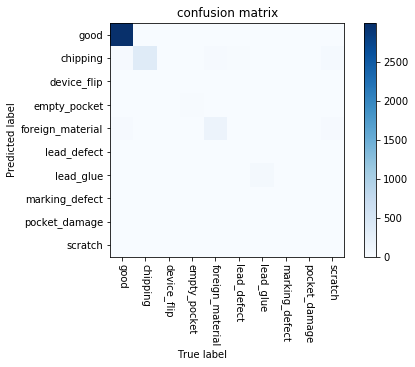

In [93]:
# confusion matrix
cm = confusion_matrix(results.label.to_numpy(), results.prediction.to_numpy())
idx = [4,0,1,2,3,5,6,7,8,9]
cm = cm[:,idx]
cm = cm[idx,:]
print(cm.T)
plot_confusion_matrix(cm.T,range(10),[class_names[i] for i in idx])

[[ 766   12]
 [  60 2992]]


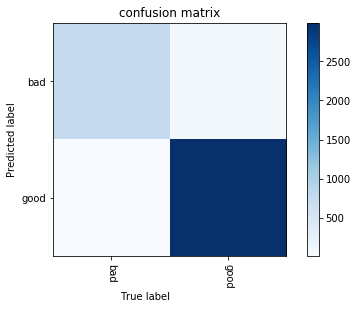

In [94]:
cm_2 = np.array([[cm[0,0], np.sum(cm[0,1:])],
                 [np.sum(cm[1:,0]), np.sum(cm[1:,1:])]])
idx_2 = [1,0]
cm_2 = cm_2[:,idx_2]
cm_2 = cm_2[idx_2,:]
print(cm_2)
plot_confusion_matrix(cm_2.T,[0,1],['bad', 'good'])

In [100]:
tpr_fm

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.99487179, 0.99487179, 0.99487179,
       0.99487179, 0.99487179, 0.99487179, 0.99487179, 0.99487179,
       0.99487179, 0.97948718, 0.97948718, 0.97435897, 0.97435897,
       0.95897436, 0.95897436, 0.95897436, 0.94871795, 0.94871795,
       0.93846154, 0.93846154, 0.93333333, 0.92820513, 0.8974359 ,
       0.8974359 , 0.89230769, 0.88205128, 0.87692308, 0.86666667,
       0.86666667, 0.86153846, 0.86153846, 0.86153846, 0.86153846,
       0.86153846, 0.86153846, 0.86153846, 0.86153846, 0.86153846,
       0.86153846, 0.86153846, 0.86153846, 0.86153846, 0.86153846,
       0.86153846, 0.86153846, 0.86153846, 0.86153846, 0.86153846,
       0.86153846, 0.86153846, 0.86153846, 0.86153846, 0.86153846,
       0.86153846, 0.86153846, 0.86153846, 0.86153846, 0.86153846,
       0.86153846, 0.86153846, 0.86153846, 0.86153846, 0.86153

In [101]:
fpr_fm

array([1.        , 0.99944979, 0.99944979, 0.99862448, 0.99807428,
       0.99697387, 0.99614856, 0.99422283, 0.53865199, 0.34002751,
       0.27565337, 0.24154058, 0.22420908, 0.21127923, 0.20440165,
       0.19449794, 0.18899587, 0.17936726, 0.16616231, 0.15350757,
       0.13727648, 0.1213205 , 0.10756534, 0.09436039, 0.08088033,
       0.07015131, 0.06574966, 0.0610729 , 0.05529574, 0.05061898,
       0.0434663 , 0.03906465, 0.03631362, 0.03301238, 0.02998624,
       0.02778542, 0.02530949, 0.02310867, 0.02255846, 0.02173315,
       0.02090784, 0.02063274, 0.02035763, 0.01953232, 0.01870702,
       0.01843191, 0.01843191, 0.01843191, 0.01815681, 0.01788171,
       0.01788171, 0.01788171, 0.01788171, 0.01788171, 0.01788171,
       0.01788171, 0.01788171, 0.01788171, 0.01788171, 0.01788171,
       0.01788171, 0.01788171, 0.01788171, 0.01788171, 0.01788171,
       0.01788171, 0.01788171, 0.01788171, 0.01788171, 0.01788171,
       0.01788171, 0.01788171, 0.01788171, 0.01788171, 0.01788

In [102]:
thresholds_fm

array([4.82711125, 4.77884014, 4.73056903, 4.68229791, 4.6340268 ,
       4.58575569, 4.53748458, 4.48921346, 4.44094235, 4.39267124,
       4.34440013, 4.29612901, 4.2478579 , 4.19958679, 4.15131568,
       4.10304456, 4.05477345, 4.00650234, 3.95823123, 3.90996011,
       3.861689  , 3.81341789, 3.76514678, 3.71687566, 3.66860455,
       3.62033344, 3.57206233, 3.52379121, 3.4755201 , 3.42724899,
       3.37897788, 3.33070676, 3.28243565, 3.23416454, 3.18589343,
       3.13762231, 3.0893512 , 3.04108009, 2.99280898, 2.94453786,
       2.89626675, 2.84799564, 2.79972453, 2.75145341, 2.7031823 ,
       2.65491119, 2.60664008, 2.55836896, 2.51009785, 2.46182674,
       2.41355563, 2.36528451, 2.3170134 , 2.26874229, 2.22047118,
       2.17220006, 2.12392895, 2.07565784, 2.02738673, 1.97911561,
       1.9308445 , 1.88257339, 1.83430228, 1.78603116, 1.73776005,
       1.68948894, 1.64121783, 1.59294671, 1.5446756 , 1.49640449,
       1.44813338, 1.39986226, 1.35159115, 1.30332004, 1.25504

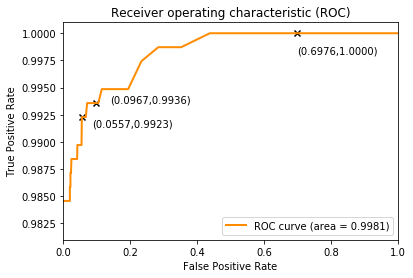

In [99]:
plt.figure()
lw = 2
plt.plot(np.append(np.linspace(0,fpr_bad[0],num=100),fpr_bad),np.append(np.ones(100)*tpr_bad[0],tpr_bad),
         color='darkorange', lw=lw, label='ROC curve (area = %0.4f)' % auc_bad)
plt.scatter(fpr_bad[-11],tpr_bad[-11],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_bad[-11],tpr_bad[-11]), # this is the text
                 (fpr_bad[-11],tpr_bad[-11]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='left')# horizontal alignment can be left, right or center
plt.scatter(fpr_bad[-23],tpr_bad[-23],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_bad[-23],tpr_bad[-23]), # this is the text
                 (fpr_bad[-23],tpr_bad[-23]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(15,0), # distance from text to points (x,y)
                 ha='left',) # horizontal alignment can be left, right or center
plt.scatter(fpr_bad[-35],tpr_bad[-35],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_bad[-35],tpr_bad[-35]), # this is the text
                 (fpr_bad[-35],tpr_bad[-35]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,-10), # distance from text to points (x,y)
                 ha='left')# horizontal alignment can be left, right or center


plt.xlim([0, 1])
plt.ylim([0.981, 1.001])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('resnet_18_ecoc_35_bits_pos_weighted_roc.jpg')
plt.show()

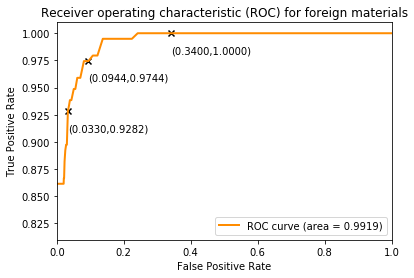

In [103]:
plt.figure()
lw = 2
plt.plot(np.append(fpr_fm,np.linspace(fpr_fm[-1],0,num=100)),np.append(tpr_fm,np.ones(100)*tpr_fm[-1]),
         color='darkorange', lw=lw, label='ROC curve (area = %0.4f)' % auc_fm)
plt.scatter(fpr_fm[9],tpr_fm[9],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_fm[9],tpr_fm[9]), # this is the text
                 (fpr_fm[9],tpr_fm[9]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='left')# horizontal alignment can be left, right or center
plt.scatter(fpr_fm[23],tpr_fm[23],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_fm[23],tpr_fm[23]), # this is the text
                 (fpr_fm[23],tpr_fm[23]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='left',) # horizontal alignment can be left, right or center
plt.scatter(fpr_fm[33],tpr_fm[33],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_fm[33],tpr_fm[33]), # this is the text
                 (fpr_fm[33],tpr_fm[33]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='left')# horizontal alignment can be left, right or center


plt.xlim([0, 1])
plt.ylim([0.81, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) for foreign materials')
plt.legend(loc="lower right")
plt.savefig('resnet_18_ecoc_35_bits_pos_weighted_fm_roc.jpg')
plt.show()

In [18]:
# test resnet_18_good_bad weighted 10 times penalty on bad data with batch size=8
model_ft.eval()
results = pd.DataFrame(columns=['id','label','prediction','score'])

running_corrects = 0
running_TP = running_TN = running_FP = running_FN = 0
running_TP_fm = running_TN_fm = running_FP_fm = running_FN_fm = 0
running_f_fm = 0
y_true = []
y_pred = []

for i, ((inputs, labels), names) in enumerate(dataloaders, 0):
    inputs = inputs.to(device)

    labels = (labels!=4).type(torch.LongTensor)
    labels = labels.to(device)


    # forward
    with torch.set_grad_enabled(False):
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
                
    running_corrects += torch.sum(preds == labels.data)
    
    TP = torch.mul(labels.data==1,preds==1).sum().item()
    FP = torch.mul(labels.data==0,preds==1).sum().item()
    TN = torch.mul(labels.data==0,preds==0).sum().item()
    FN = torch.mul(labels.data==1,preds==0).sum().item()

    running_TP += TP
    running_FP += FP
    running_TN += TN
    running_FN += FN
    
    m = nn.Softmax(dim=1)
    probs = m(outputs)

    y_true.append(labels.data.cpu())
    y_pred.append(probs.cpu())
    
    result = pd.DataFrame({'id':names,'label':labels.detach().cpu(),'prediction':preds.detach().cpu(),'score':probs.detach().cpu()})
    results = results.append(result)

acc = running_corrects.double() / dataset_sizes

if (running_TP+running_FN==0):
    TPR = float('nan')
else:
    TPR = running_TP / (running_TP + running_FN)
if (running_TN+running_FP==0):
    TNR = float('nan')
else:
    TNR = running_TN / (running_TN + running_FP)

y_true = torch.cat(y_true)
y_pred = torch.cat(y_pred)[:,1]
auc_ovr = roc_auc_score(y_true, y_pred,average='weighted',multi_class='ovr')
# auc_ovo = roc_auc_score(y_true, y_pred,average='weighted',multi_class='ovo')

print('Test acc: {:.4f} TPR: {:.4f} TNR: {:.4f} AUC: {:.4f}'
      .format(acc, TPR, TNR, auc_ovr))

results.to_csv('test_result_resnet_18_2_classes_weighted_10_times_penalty_bad_batch_size_8.csv',index=False)

KeyboardInterrupt: 

[[ 766   93]
 [  12 2959]]


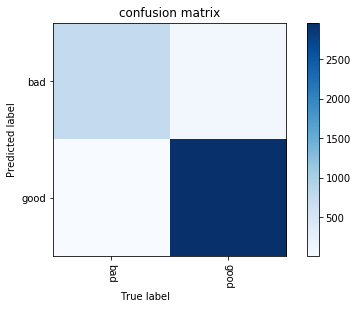

In [50]:
# confusion matrix
cm = confusion_matrix(results.label.to_numpy().astype(int), results.prediction.to_numpy().astype(int))
idx = [1,0]
cm = cm[:,idx]
cm = cm[idx,:]
print(cm.T)
classes = ['good', 'bad']
plot_confusion_matrix(cm.T,range(2),[classes[i] for i in idx])

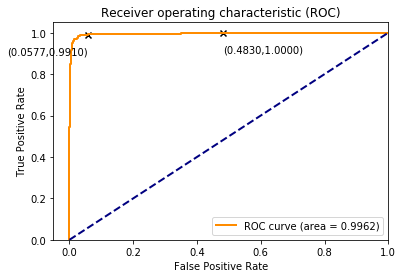

In [51]:
fpr_7, tpr_7, thresholds_7 = roc_curve(y_true, y_pred)

plt.figure()
lw = 2
plt.plot(fpr_7, tpr_7, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % auc_ovr)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.scatter(fpr_7[-3],tpr_7[-3],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_7[-2],tpr_7[-2]), # this is the text
                 (fpr_7[-3],tpr_7[-3]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='left')# horizontal alignment can be left, right or center
plt.scatter(fpr_7[-15],tpr_7[-15],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_7[-15],tpr_7[-15]), # this is the text
                 (fpr_7[-15],tpr_7[-15]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='right',) # horizontal alignment can be left, right or center

plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('resnet_18_2_classes_weighted_10_times_penalty_bad_batch_size_8_roc.jpg')
plt.show()

In [39]:
# test resnet_18_good_bad weighted
model_ft.eval()
results = pd.DataFrame(columns=['id','label','prediction','score'])

running_corrects = 0
running_TP = running_TN = running_FP = running_FN = 0
running_TP_fm = running_TN_fm = running_FP_fm = running_FN_fm = 0
running_f_fm = 0
y_true = []
y_pred = []

for i, ((inputs, labels), names) in enumerate(dataloaders, 0):
    inputs = inputs.to(device)

    labels = (labels!=4).type(torch.LongTensor)
    labels = labels.to(device)


    # forward
    with torch.set_grad_enabled(False):
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
                
    running_corrects += torch.sum(preds == labels.data)
    
    TP = torch.mul(labels.data==1,preds==1).sum().item()
    FP = torch.mul(labels.data==0,preds==1).sum().item()
    TN = torch.mul(labels.data==0,preds==0).sum().item()
    FN = torch.mul(labels.data==1,preds==0).sum().item()

    running_TP += TP
    running_FP += FP
    running_TN += TN
    running_FN += FN
    
    m = nn.Softmax(dim=1)
    probs = m(outputs)

    y_true.append(labels.data.cpu())
    y_pred.append(probs.cpu())
    
    result = pd.DataFrame({'id':names,'label':labels.detach().cpu(),'prediction':preds.detach().cpu(),'score':probs.detach().cpu()})
    results = results.append(result)

acc = running_corrects.double() / dataset_sizes

if (running_TP+running_FN==0):
    TPR = float('nan')
else:
    TPR = running_TP / (running_TP + running_FN)
if (running_TN+running_FP==0):
    TNR = float('nan')
else:
    TNR = running_TN / (running_TN + running_FP)

y_true = torch.cat(y_true)
y_pred = torch.cat(y_pred)[:,1]
auc_ovr = roc_auc_score(y_true, y_pred,average='weighted',multi_class='ovr')
# auc_ovo = roc_auc_score(y_true, y_pred,average='weighted',multi_class='ovo')

print('Test acc: {:.4f} TPR: {:.4f} TNR: {:.4f} AUC: {:.4f}'
      .format(acc, TPR, TNR, auc_ovr))

results.to_csv('test_result_resnet_18_2_classes_weighted.csv',index=False)

Test acc: 0.9830 TPR: 0.9769 TNR: 0.9846 AUC: 0.9958


In [70]:
torch.ones(len(labels))*2

tensor([2., 2., 2., 2., 2., 2.])

[[ 760   47]
 [  18 3005]]


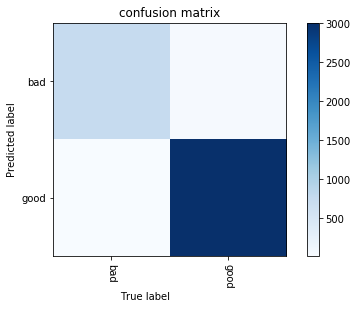

In [40]:
# confusion matrix
cm = confusion_matrix(results.label.to_numpy().astype(int), results.prediction.to_numpy().astype(int))
idx = [1,0]
cm = cm[:,idx]
cm = cm[idx,:]
print(cm.T)
classes = ['good', 'bad']
plot_confusion_matrix(cm.T,range(2),[classes[i] for i in idx])

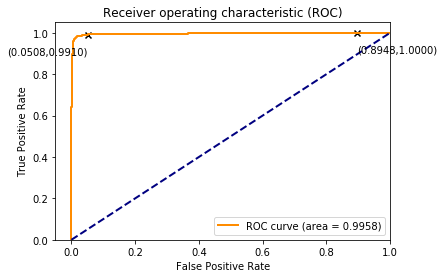

In [41]:
fpr_6, tpr_6, thresholds_6 = roc_curve(y_true, y_pred)

plt.figure()
lw = 2
plt.plot(fpr_6, tpr_6, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % auc_ovr)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.scatter(fpr_6[-3],tpr_6[-3],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_6[-2],tpr_6[-2]), # this is the text
                 (fpr_6[-3],tpr_6[-3]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='left')# horizontal alignment can be left, right or center
plt.scatter(fpr_6[-15],tpr_6[-15],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_6[-15],tpr_6[-15]), # this is the text
                 (fpr_6[-15],tpr_6[-15]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='right',) # horizontal alignment can be left, right or center

plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('resnet_18_2_classes_weighted_roc.jpg')
plt.show()

In [9]:
# test resnet_18_good_bad weighted 10 times penalty on bad data
model_ft.eval()
results = pd.DataFrame(columns=['id','label','prediction','score'])

running_corrects = 0
running_TP = running_TN = running_FP = running_FN = 0
running_TP_fm = running_TN_fm = running_FP_fm = running_FN_fm = 0
running_f_fm = 0
y_true = []
y_pred = []

for i, ((inputs, labels), names) in enumerate(dataloaders, 0):
    inputs = inputs.to(device)

    labels = (labels!=4).type(torch.LongTensor)
    labels = labels.to(device)


    # forward
    with torch.set_grad_enabled(False):
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
                
    running_corrects += torch.sum(preds == labels.data)
    
    TP = torch.mul(labels.data==1,preds==1).sum().item()
    FP = torch.mul(labels.data==0,preds==1).sum().item()
    TN = torch.mul(labels.data==0,preds==0).sum().item()
    FN = torch.mul(labels.data==1,preds==0).sum().item()

    running_TP += TP
    running_FP += FP
    running_TN += TN
    running_FN += FN
    
    m = nn.Softmax(dim=1)
    probs = m(outputs)

    y_true.append(labels.data.cpu())
    y_pred.append(probs.cpu())
    
    result = pd.DataFrame({'id':names,'label':labels.detach().cpu(),'prediction':preds.detach().cpu(),'score':probs.detach().cpu()})
    results = results.append(result)

acc = running_corrects.double() / dataset_sizes

if (running_TP+running_FN==0):
    TPR = float('nan')
else:
    TPR = running_TP / (running_TP + running_FN)
if (running_TN+running_FP==0):
    TNR = float('nan')
else:
    TNR = running_TN / (running_TN + running_FP)

y_true = torch.cat(y_true)
y_pred = torch.cat(y_pred)[:,1]
auc_ovr = roc_auc_score(y_true, y_pred,average='weighted',multi_class='ovr')
# auc_ovo = roc_auc_score(y_true, y_pred,average='weighted',multi_class='ovo')

print('Test acc: {:.4f} TPR: {:.4f} TNR: {:.4f} AUC: {:.4f}'
      .format(acc, TPR, TNR, auc_ovr))

results.to_csv('test_result_resnet_18_2_classes_weighted_10_times_penalty_bad.csv',index=False)

Test acc: 0.9564 TPR: 0.9884 TNR: 0.9482 AUC: 0.9964


[[ 769  158]
 [   9 2894]]


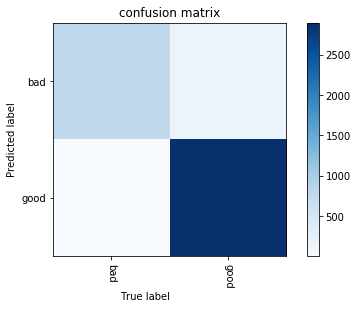

In [25]:
# confusion matrix
cm = confusion_matrix(results.label.to_numpy().astype(int), results.prediction.to_numpy().astype(int))
idx = [1,0]
cm = cm[:,idx]
cm = cm[idx,:]
print(cm.T)
classes = ['good', 'bad']
plot_confusion_matrix(cm.T,range(2),[classes[i] for i in idx])

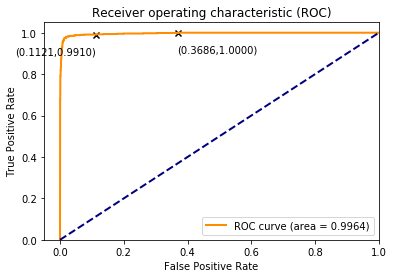

In [34]:
fpr_5, tpr_5, thresholds_5 = roc_curve(y_true, y_pred)

plt.figure()
lw = 2
plt.plot(fpr_5, tpr_5, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % auc_ovr)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.scatter(fpr_5[-3],tpr_5[-3],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_5[-2],tpr_5[-2]), # this is the text
                 (fpr_5[-3],tpr_5[-3]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='left')# horizontal alignment can be left, right or center
plt.scatter(fpr_5[-15],tpr_5[-15],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_5[-15],tpr_5[-15]), # this is the text
                 (fpr_5[-15],tpr_5[-15]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='right',) # horizontal alignment can be left, right or center

plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('resnet_18_2_classes_weighted_10_times_penalty_bad_roc.jpg')
plt.show()

In [33]:
# test resnet_18_good_bad
model_ft.eval()
results = pd.DataFrame(columns=['id','label','prediction','score'])

running_corrects = 0
running_TP = running_TN = running_FP = running_FN = 0
running_TP_fm = running_TN_fm = running_FP_fm = running_FN_fm = 0
running_f_fm = 0
y_true = []
y_pred = []

for i, ((inputs, labels), names) in enumerate(dataloaders, 0):
    inputs = inputs.to(device)

    labels = (labels!=4).type(torch.LongTensor)
    labels = labels.to(device)


    # forward
    with torch.set_grad_enabled(False):
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
                
    running_corrects += torch.sum(preds == labels.data)
    
    TP = torch.mul(labels.data==1,preds==1).sum().item()
    FP = torch.mul(labels.data==0,preds==1).sum().item()
    TN = torch.mul(labels.data==0,preds==0).sum().item()
    FN = torch.mul(labels.data==1,preds==0).sum().item()

    running_TP += TP
    running_FP += FP
    running_TN += TN
    running_FN += FN
    
    m = nn.Softmax(dim=1)
    probs = m(outputs)

    y_true.append(labels.data.cpu())
    y_pred.append(probs.cpu())
    
    result = pd.DataFrame({'id':names,'label':labels.detach().cpu(),'prediction':preds.detach().cpu(),'score':probs.detach().cpu()})
    results = results.append(result)

acc = running_corrects.double() / dataset_sizes

if (running_TP+running_FN==0):
    TPR = float('nan')
else:
    TPR = running_TP / (running_TP + running_FN)
if (running_TN+running_FP==0):
    TNR = float('nan')
else:
    TNR = running_TN / (running_TN + running_FP)

y_true = torch.cat(y_true)
y_pred = torch.cat(y_pred)[:,1]
auc_ovr = roc_auc_score(y_true, y_pred,average='weighted',multi_class='ovr')
# auc_ovo = roc_auc_score(y_true, y_pred,average='weighted',multi_class='ovo')

print('Test acc: {:.4f} TPR: {:.4f} TNR: {:.4f} AUC: {:.4f}'
      .format(acc, TPR, TNR, auc_ovr))

results.to_csv('test_result_resnet_18_good_bad.csv',index=False)

Test acc: 0.9875 TPR: 0.9717 TNR: 0.9915 AUC: 0.9968


In [37]:
results.label.unique()

array([0, 1], dtype=object)

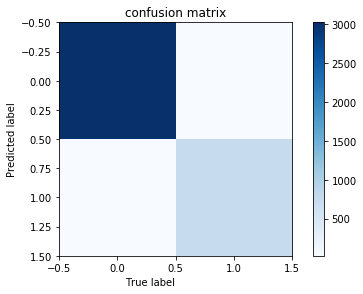

In [42]:
# confusion matrix
cm = confusion_matrix(y_true, y_pred>=0.5)
# cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm.T)

In [348]:
# test resnet_18_weighted with heavier penalty on bad data especially for foreign material defect
model_ft.eval()
results = pd.DataFrame(columns=['id','label'])

running_corrects = 0
running_TP = running_TN = running_FP = running_FN = 0
running_TP_fm = running_TN_fm = running_FP_fm = running_FN_fm = 0
running_f_fm = 0
y_true = []
y_pred = []

for i, ((inputs, labels), names) in enumerate(dataloaders, 0):
    inputs = inputs.to(device)
    labels = labels.to(device)

    # forward
    with torch.set_grad_enabled(False):
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
                
    running_corrects += torch.sum(preds == labels.data)
    
    TP, FP, TN, FN = perf_measure_bad(labels.data,preds)            
    running_TP += TP
    running_FP += FP
    running_TN += TN
    running_FN += FN
    
    TP_fm, FP_fm, TN_fm, FN_fm = perf_measure_fm(labels.data,preds)            
    running_TP_fm += TP_fm
    running_FP_fm += FP_fm
    running_TN_fm += TN_fm
    running_FN_fm += FN_fm

    f_fm = good_to_false_fm(labels.data,preds)
    running_f_fm += f_fm

    m = nn.Softmax(dim=1)
    probs = m(outputs)

    y_true.append(labels.data.cpu())
    y_pred.append(probs.cpu())
    
    result = pd.DataFrame({'id':names,'label':labels.detach().cpu(),'prediction':preds.detach().cpu()})
    for i, class_name in enumerate(class_names):
        result['{}_score'.format(class_name)] = probs.detach().cpu()[:,i]
    results = results.append(result)

acc = running_corrects.double() / dataset_sizes

if (running_TP+running_FN==0):
    TPR = float('nan')
else:
    TPR = running_TP / (running_TP + running_FN)
if (running_TN+running_FP==0):
    TNR = float('nan')
else:
    TNR = running_TN / (running_TN + running_FP)

if (running_TP_fm+running_FN_fm==0):
    TPR_fm = float('nan')
else:
    TPR_fm = running_TP_fm / (running_TP_fm + running_FN_fm)
if (running_TN_fm+running_FP_fm==0):
    TNR_fm = float('nan')
else:
    TNR_fm = running_TN_fm / (running_TN_fm + running_FP_fm)
            
if (running_FP==0):
    f_fm_rate = float('nan')
else:
    f_fm_rate = running_f_fm / running_FP

y_true = torch.cat(y_true)
y_pred = torch.cat(y_pred)
y_bad = y_true!=4
y_fm = y_true==3
y_bad_score = torch.cat((y_pred[:,:4],y_pred[:,5:]),1).sum(1)
y_fm_score = y_pred[:,3]
auc_bad = roc_auc_score(y_bad, y_bad_score,average='weighted')
auc_fm = roc_auc_score(y_fm, y_fm_score,average='weighted')
auc_ovr = roc_auc_score(y_true, y_pred,average='weighted',multi_class='ovr')
# auc_ovo = roc_auc_score(y_true, y_pred,average='weighted',multi_class='ovo')

print('Test acc: {:.4f} TPR: {:.4f} TNR: {:.4f} TPR_fm: {:.4f} TNR_fm: {:.4f} fm/FP: {:.4f} AUC_bad: {:.4f} AUC_fm: {:.4f} AUC: {:.4f}'
      .format(acc, TPR, TNR, TPR_fm, TNR_fm, f_fm_rate, auc_bad, auc_fm, auc_ovr))

results['label'] = results['label'].apply(lambda i: class_names[i])
results['prediction'] = results['prediction'].astype('int').apply(lambda i: class_names[i])

results.to_csv('test_result_resnet_18_weighted_overall_heavier_penalty_esp_for_fm.csv',index=False)

Test acc: 0.7094 TPR: 0.9961 TNR: 0.6740 TPR_fm: 0.9487 TNR_fm: 0.8418 fm/FP: 0.5327 AUC_bad: 0.9841 AUC_fm: 0.9616 AUC: 0.9808


In [9]:
model_dict['test_acc'] = acc
model_dict['test_TPR'] = TPR
model_dict['test_TNR'] = TNR
model_dict['test_TPR_fm'] = TPR_fm
model_dict['test_TNR_fm'] = TNR_fm
model_dict['test_f_fm_rate'] = f_fm_rate
model_dict['test_AUC_bad'] = auc_bad
model_dict['test_AUC_fm'] = auc_fm
model_dict['test_AUC'] = auc_ovr
torch.save(model_dict,'resnet_18_dict_weighted_overall_heavier_penalty_esp_for_fm.pt')

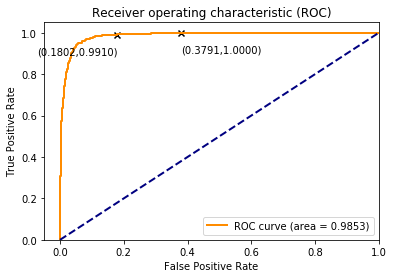

In [338]:
fpr_4, tpr_4, thresholds_4 = roc_curve(y_bad, y_bad_score)

plt.figure()
lw = 2
plt.plot(fpr_4, tpr_4, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % auc_bad)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.scatter(fpr_4[-2],tpr_4[-2],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_4[-2],tpr_4[-2]), # this is the text
                 (fpr_4[-2],tpr_4[-2]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='left')# horizontal alignment can be left, right or center
plt.scatter(fpr_4[-15],tpr_4[-15],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_4[-15],tpr_4[-15]), # this is the text
                 (fpr_4[-15],tpr_4[-15]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='right',) # horizontal alignment can be left, right or center

plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('resnet_18_weighted_overall_heavier_penalty_esp_for_fm_roc.jpg')
plt.show()

[[2041    0    1    0    0    0    0    0    0    1]
 [ 108  310    0    0    4    1    0    0    0   14]
 [   6    0   12    0    0    0    0    0    0    0]
 [   0    0    0   20    0    0    0    0    0    0]
 [ 514   17    0    0  185    2    0    0    1   28]
 [ 198    1    1    0    1   20    0    0    0    1]
 [  70    3    0    0    1    1   62    0    0    0]
 [  25    0    0    0    0    1    0   18    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [  90   37    0    0    4    0    0    0    0   31]]


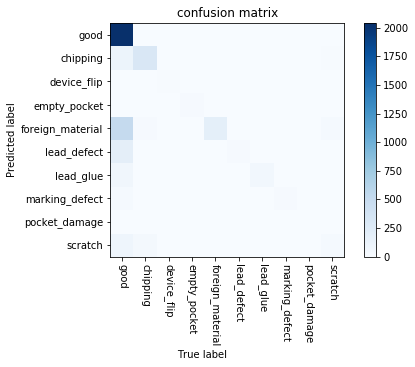

In [342]:
# confusion matrix
cm = confusion_matrix(results.label.to_numpy(), results.prediction.to_numpy())
idx = [4,0,1,2,3,5,6,7,8,9]
cm = cm[:,idx]
cm = cm[idx,:]
print(cm.T)
plot_confusion_matrix(cm.T,range(10),[class_names[i] for i in idx])

[[ 776    2]
 [1011 2041]]


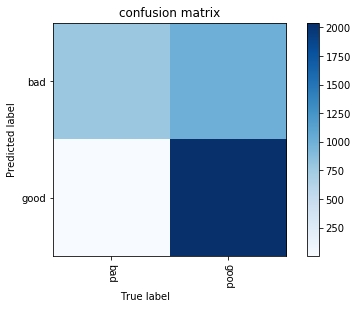

In [343]:
cm_2 = np.array([[cm[0,0], np.sum(cm[0,1:])],
                 [np.sum(cm[1:,0]), np.sum(cm[1:,1:])]])
idx_2 = [1,0]
cm_2 = cm_2[:,idx_2]
cm_2 = cm_2[idx_2,:]
print(cm_2)
plot_confusion_matrix(cm_2.T,[0,1],['bad', 'good'])

[[ 185   10]
 [ 562 3073]]


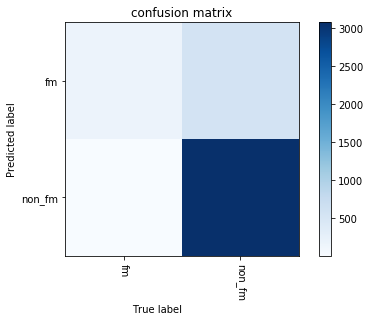

In [344]:
# confusion matrix fm
cm = confusion_matrix(results.label.to_numpy(), results.prediction.to_numpy())
idx = [3,0,1,2,4,5,6,7,8,9]
cm = cm[:,idx]
cm = cm[idx,:]
cm_2 = np.array([[cm[0,0], np.sum(cm[0,1:])],
                 [np.sum(cm[1:,0]), np.sum(cm[1:,1:])]])
print(cm_2)
plot_confusion_matrix(cm_2.T,[0,1],['fm', 'non_fm'])

In [159]:
class_names

['chipping',
 'device_flip',
 'empty_pocket',
 'foreign_material',
 'good',
 'lead_defect',
 'lead_glue',
 'marking_defect',
 'pocket_damage',
 'scratch']

In [349]:
results[(results['label']!=results['prediction']) & (results['prediction']=='good')].groupby(['prediction','label']).count()[['id']]

id
prediction label          
good       chipping      1
           lead_defect   1
           scratch       1

In [298]:
results[(results['label']!=results['prediction']) & (results['prediction']=='good')]['id']

9    /home/kaiyihuang/nexperia/new_data/test/chippi...
5    /home/kaiyihuang/nexperia/new_data/test/lead_d...
0    /home/kaiyihuang/nexperia/new_data/test/lead_d...
Name: id, dtype: object

In [350]:
for i in results[(results['label']!=results['prediction']) & (results['prediction']=='good')]['id']:
    print(i)
    # open method used to open different extension image file 
    im = Image.open(i)  

    # This method will show image in any image viewer  
    im.show() 

/home/kaiyihuang/nexperia/new_data/test/lead_defect/WEL93514258A_55-APG_ITIS_H09_1_67_3.bmp
/home/kaiyihuang/nexperia/new_data/test/chipping/WEP93855011A_01-APG_ITIS_H46_1_76_4.bmp
/home/kaiyihuang/nexperia/new_data/test/scratch/WEP938425D5A_01-APG_ITIS_H52_2_397_2.bmp


In [310]:
im = Image.open('/home/kaiyihuang/nexperia/new_data/test/chipping/WEP93734754A_02-APG_ITIS_H09_1_859_3.bmp')  

# This method will show image in any image viewer  
im.show() 

In [269]:
results[(results['label']!=results['prediction']) & (results['label']=='foreign_material')].groupby(['label','prediction']).count()[['id']]

id
label            prediction     
foreign_material chipping      5
                 lead_defect   1
                 scratch       6

In [12]:
results[(results['label']!=results['prediction']) & (results['label']=='good')].groupby(['label','prediction']).count()[['id']]

id
label prediction           
good  chipping          105
      device_flip         3
      foreign_material  518
      lead_defect       209
      lead_glue          71
      marking_defect     25
      scratch            77

In [13]:
results[(results['label']!=results['prediction']) & (results['prediction']=='foreign_material')].groupby(['prediction','label']).count()[['id']]

id
prediction       label             
foreign_material chipping        23
                 good           518
                 lead_defect      3
                 pocket_damage    1
                 scratch         29

In [334]:
# test resnet_18_weighted with heavier penalty on falsely predict an actual foreign material defect
model_ft.eval()
results = pd.DataFrame(columns=['id','label'])

running_corrects = 0
running_TP = running_TN = running_FP = running_FN = 0
running_TP_fm = running_TN_fm = running_FP_fm = running_FN_fm = 0
running_f_fm = 0
y_true = []
y_pred = []

for i, ((inputs, labels), names) in enumerate(dataloaders, 0):
    inputs = inputs.to(device)
    labels = labels.to(device)

    # forward
    with torch.set_grad_enabled(False):
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
                
    running_corrects += torch.sum(preds == labels.data)
    
    TP, FP, TN, FN = perf_measure_bad(labels.data,preds)            
    running_TP += TP
    running_FP += FP
    running_TN += TN
    running_FN += FN
    
    TP_fm, FP_fm, TN_fm, FN_fm = perf_measure_fm(labels.data,preds)            
    running_TP_fm += TP_fm
    running_FP_fm += FP_fm
    running_TN_fm += TN_fm
    running_FN_fm += FN_fm

    f_fm = good_to_false_fm(labels.data,preds)
    running_f_fm += f_fm

    m = nn.Softmax(dim=1)
    probs = m(outputs)

    y_true.append(labels.data.cpu())
    y_pred.append(probs.cpu())
    
    result = pd.DataFrame({'id':names,'label':labels.detach().cpu(),'prediction':preds.detach().cpu()})
    for i, class_name in enumerate(class_names):
        result['{}_score'.format(class_name)] = probs.detach().cpu()[:,i]
    results = results.append(result)

acc = running_corrects.double() / dataset_sizes

if (running_TP+running_FN==0):
    TPR = float('nan')
else:
    TPR = running_TP / (running_TP + running_FN)
if (running_TN+running_FP==0):
    TNR = float('nan')
else:
    TNR = running_TN / (running_TN + running_FP)

if (running_TP_fm+running_FN_fm==0):
    TPR_fm = float('nan')
else:
    TPR_fm = running_TP_fm / (running_TP_fm + running_FN_fm)
if (running_TN_fm+running_FP_fm==0):
    TNR_fm = float('nan')
else:
    TNR_fm = running_TN_fm / (running_TN_fm + running_FP_fm)
            
if (running_FP==0):
    f_fm_rate = float('nan')
else:
    f_fm_rate = running_f_fm / running_FP

y_true = torch.cat(y_true)
y_pred = torch.cat(y_pred)
y_bad = y_true!=4
y_fm = y_true==3
y_bad_score = torch.cat((y_pred[:,:4],y_pred[:,5:]),1).sum(1)
y_fm_score = y_pred[:,3]
auc_bad = roc_auc_score(y_bad, y_bad_score,average='weighted')
auc_fm = roc_auc_score(y_fm, y_fm_score,average='weighted')
auc_ovr = roc_auc_score(y_true, y_pred,average='weighted',multi_class='ovr')
# auc_ovo = roc_auc_score(y_true, y_pred,average='weighted',multi_class='ovo')

print('Test acc: {:.4f} TPR: {:.4f} TNR: {:.4f} TPR_fm: {:.4f} TNR_fm: {:.4f} fm/FP: {:.4f} AUC_bad: {:.4f} AUC_fm: {:.4f} AUC: {:.4f}'
      .format(acc, TPR, TNR, TPR_fm, TNR_fm, f_fm_rate, auc_bad, auc_fm, auc_ovr))

results['label'] = results['label'].apply(lambda i: class_names[i])
results['prediction'] = results['prediction'].astype('int').apply(lambda i: class_names[i])

results.to_csv('test_result_resnet_18_weighted_heavier_penalty_fm',index=False)

Test acc: 0.9277 TPR: 0.9743 TNR: 0.9548 TPR_fm: 0.9282 TNR_fm: 0.9623 fm/FP: 0.5652 AUC_bad: 0.9937 AUC_fm: 0.9885 AUC: 0.9922


In [25]:
model_dict['test_acc'] = acc
model_dict['test_TPR'] = TPR
model_dict['test_TNR'] = TNR
model_dict['test_TPR_fm'] = TPR_fm
model_dict['test_TNR_fm'] = TNR_fm
model_dict['test_f_fm_rate'] = f_fm_rate
model_dict['test_AUC_bad'] = auc_bad
model_dict['test_AUC_fm'] = auc_fm
model_dict['test_AUC'] = auc_ovr
torch.save(model_dict,'resnet_18_dict_weighted_heavier_penalty_fm.pt')

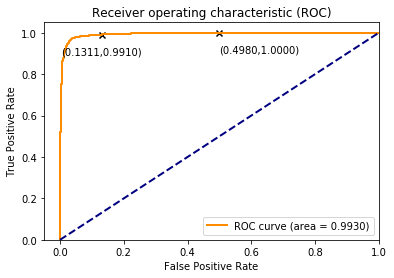

In [333]:
fpr_3, tpr_3, thresholds_3 = roc_curve(y_bad, y_bad_score)

plt.figure()
lw = 2
plt.plot(fpr_3, tpr_3, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % auc_bad)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.scatter(fpr_3[-2],tpr_3[-2],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_3[-2],tpr_3[-2]), # this is the text
                 (fpr_3[-2],tpr_3[-2]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='left')# horizontal alignment can be left, right or center
plt.scatter(fpr_3[-15],tpr_3[-15],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_3[-15],tpr_3[-15]), # this is the text
                 (fpr_3[-15],tpr_3[-15]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center',) # horizontal alignment can be left, right or center

plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('resnet_18_weighted_heavier_penalty_fm_roc.jpg')
plt.show()

[[2908   19    0    0   83   11    9    2    0   20]
 [  12  294    0    0   21    1    0    0    0   40]
 [   1    0   13    0    0    0    0    0    0    0]
 [   0    0    0   20    0    0    0    0    0    0]
 [   3    5    0    0  180    1    1    0    0    5]
 [   3    2    0    0    1   19    0    0    0    0]
 [   0    0    0    0    0    0   62    0    0    0]
 [   0    0    0    0    0    0    0   18    0    0]
 [   0    0    0    0    1    0    0    0    0    0]
 [   3   14    0    0   25    0    1    0    0   32]]


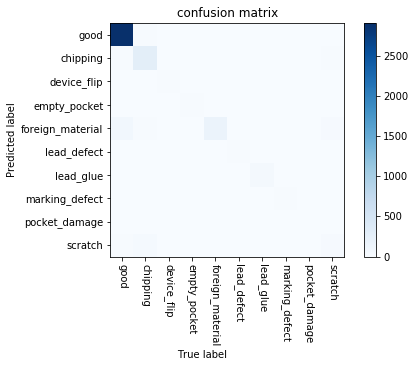

In [170]:
# confusion matrix
cm = confusion_matrix(results.label.to_numpy(), results.prediction.to_numpy())
idx = [4,0,1,2,3,5,6,7,8,9]
cm = cm[:,idx]
cm = cm[idx,:]
print(cm)
plot_confusion_matrix(cm.T,range(10),[class_names[i] for i in idx])

[[ 756   22]
 [ 144 2908]]


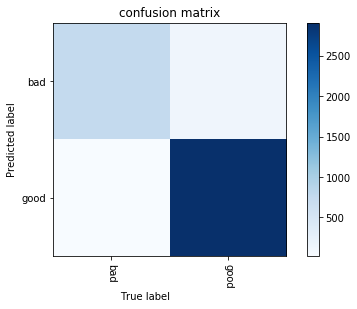

In [171]:
cm_2 = np.array([[cm[0,0], np.sum(cm[0,1:])],
                 [np.sum(cm[1:,0]), np.sum(cm[1:,1:])]])
idx_2 = [1,0]
cm_2 = cm_2[:,idx_2]
cm_2 = cm_2[idx_2,:]
print(cm_2)
plot_confusion_matrix(cm_2.T,[0,1],['bad', 'good'])

[[ 180   15]
 [ 131 3504]]


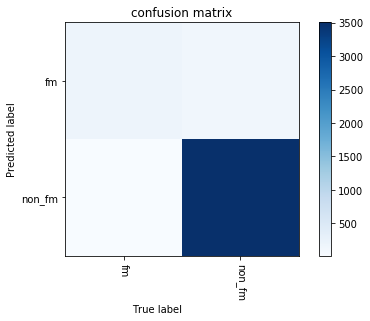

In [172]:
# confusion matrix fm
cm = confusion_matrix(results.label.to_numpy(), results.prediction.to_numpy())
idx = [3,0,1,2,4,5,6,7,8,9]
cm = cm[:,idx]
cm = cm[idx,:]
cm_2 = np.array([[cm[0,0], np.sum(cm[0,1:])],
                 [np.sum(cm[1:,0]), np.sum(cm[1:,1:])]])
print(cm_2)
plot_confusion_matrix(cm_2.T,[0,1],['fm', 'non_fm'])

In [146]:
np.concatenate((np.array(cm[0,0]).reshape(1,1), np.sum(cm[:,1:],axis=1).reshape(1,-1)),axis=1).shape

(1, 11)

In [148]:
cm[:,1:].shape

(10, 9)

In [36]:
results[(results['label']!=results['prediction']) & (results['prediction']=='good')].groupby(['prediction','label']).count()[['id']]

id
prediction label               
good       chipping          12
           device_flip        1
           foreign_material   1
           lead_defect        3
           scratch            3

In [37]:
results[(results['label']!=results['prediction']) & (results['label']=='foreign_material')].groupby(['label','prediction']).count()[['id']]

id
label            prediction     
foreign_material chipping      6
                 good          1
                 lead_defect   1
                 scratch       5

In [15]:
# test resnet_18_weighted with batch_size=8
model_ft.eval()
results = pd.DataFrame(columns=['id','label'])

running_corrects = running_TP = running_TN = running_FP = running_FN = 0

for i, ((inputs, labels), names) in enumerate(dataloaders, 0):
    inputs = inputs.to(device)
    labels = labels.to(device)

    # forward
    with torch.set_grad_enabled(False):
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
                
    running_corrects += torch.sum(preds == labels.data)
    
    TP, FP, TN, FN = perf_measure(labels.data,preds)            
    running_TP += TP
    running_FP += FP
    running_TN += TN
    running_FN += FN
    
    result = pd.DataFrame({'id':names,'label':labels.data.cpu(),'prediction':preds.cpu()})
    results = results.append(result)


    
acc = running_corrects.double() / dataset_sizes

if (running_TP+running_FN==0):
    TPR = float('nan')
else:
    TPR = running_TP / (running_TP + running_FN)
if (running_TN+running_FP==0):
    TNR = float('nan')
else:
    TNR = running_TN / (running_TN + running_FP)

print('Test acc: {:.4f} TPR: {:.4f} TNR: {:.4f}'.format(acc, TPR, TNR))

results.to_csv('test_result_resnet_18_weighted_batch_size_8.csv',index=False)

Test acc: 0.9559 TPR: 0.9756 TNR: 0.9780


In [16]:
results[(results['label']!=results['prediction']) & (results['prediction']==4)].groupby(['label']).count()

,id,prediction
label,,
0,8,8
1,1,1
3,7,7
5,2,2
9,1,1


In [17]:
results[results['label']!=results['prediction']].groupby(['prediction','label']).count()

id
prediction label    
0.0        3       7
           4      24
           5       1
           9      15
3.0        0       4
           4      27
           5       1
           8       1
           9      17
4.0        0       8
           1       1
           3       7
           5       2
           9       1
5.0        4       5
           9       1
6.0        4       2
7.0        4       2
9.0        0      26
           3      10
           4       7

In [18]:
results[results['label']!=results['prediction']].groupby(['label','prediction']).count()

id
label prediction    
0     3.0          4
      4.0          8
      9.0         26
1     4.0          1
3     0.0          7
      4.0          7
      9.0         10
4     0.0         24
      3.0         27
      5.0          5
      6.0          2
      7.0          2
      9.0          7
5     0.0          1
      3.0          1
      4.0          2
8     3.0          1
9     0.0         15
      3.0         17
      4.0          1
      5.0          1

In [42]:
# test resnet_18_weighted
model_ft.eval()
results = pd.DataFrame(columns=['id','label'])

running_corrects = 0
running_TP = running_TN = running_FP = running_FN = 0
running_TP_fm = running_TN_fm = running_FP_fm = running_FN_fm = 0
running_f_fm = 0
y_true = []
y_pred = []

for i, ((inputs, labels), names) in enumerate(dataloaders, 0):
    inputs = inputs.to(device)
    labels = labels.to(device)

    # forward
    with torch.set_grad_enabled(False):
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
                
    running_corrects += torch.sum(preds == labels.data)
    
    TP, FP, TN, FN = perf_measure_bad(labels.data,preds)            
    running_TP += TP
    running_FP += FP
    running_TN += TN
    running_FN += FN
    
    TP_fm, FP_fm, TN_fm, FN_fm = perf_measure_fm(labels.data,preds)            
    running_TP_fm += TP_fm
    running_FP_fm += FP_fm
    running_TN_fm += TN_fm
    running_FN_fm += FN_fm

    f_fm = good_to_false_fm(labels.data,preds)
    running_f_fm += f_fm

    m = nn.Softmax(dim=1)
    probs = m(outputs)

    y_true.append(labels.data.cpu())
    y_pred.append(probs.cpu())
    
    result = pd.DataFrame({'id':names,'label':labels.detach().cpu(),'prediction':preds.detach().cpu()})
    for i, class_name in enumerate(class_names):
        result['{}_score'.format(class_name)] = probs.detach().cpu()[:,i]
    results = results.append(result)

acc = running_corrects.double() / dataset_sizes

if (running_TP+running_FN==0):
    TPR = float('nan')
else:
    TPR = running_TP / (running_TP + running_FN)
if (running_TN+running_FP==0):
    TNR = float('nan')
else:
    TNR = running_TN / (running_TN + running_FP)

if (running_TP_fm+running_FN_fm==0):
    TPR_fm = float('nan')
else:
    TPR_fm = running_TP_fm / (running_TP_fm + running_FN_fm)
if (running_TN_fm+running_FP_fm==0):
    TNR_fm = float('nan')
else:
    TNR_fm = running_TN_fm / (running_TN_fm + running_FP_fm)
            
if (running_FP==0):
    f_fm_rate = float('nan')
else:
    f_fm_rate = running_f_fm / running_FP

y_true = torch.cat(y_true)
y_pred = torch.cat(y_pred)
y_bad = y_true!=4
y_fm = y_true==3
y_bad_score = torch.cat((y_pred[:,:4],y_pred[:,5:]),1).sum(1)
y_fm_score = y_pred[:,3]
auc_bad = roc_auc_score(y_bad, y_bad_score,average='weighted')
auc_fm = roc_auc_score(y_fm, y_fm_score,average='weighted')
auc_ovr = roc_auc_score(y_true, y_pred,average='weighted',multi_class='ovr')
auc_ovo = roc_auc_score(y_true, y_pred,average='weighted',multi_class='ovo')

print('Test acc: {:.4f} TPR: {:.4f} TNR: {:.4f} TPR_fm: {:.4f} TNR_fm: {:.4f} fm/FP: {:.4f} AUC_bad: {:.4f} AUC_fm: {:.4f} AUC: {:.4f}'
      .format(acc, TPR, TNR, TPR_fm, TNR_fm, f_fm_rate, auc_bad, auc_fm, auc_ovr))

results['label'] = results['label'].apply(lambda i: class_names[i])
results['prediction'] = results['prediction'].astype('int').apply(lambda i: class_names[i])

results.to_csv('test_result_resnet_18_weighted.csv',index=False)

Test acc: 0.9381 TPR: 0.9846 TNR: 0.9594 TPR_fm: 0.8513 TNR_fm: 0.9860 fm/FP: 0.2339 AUC_bad: 0.9961 AUC_fm: 0.9868 AUC: 0.9942


In [10]:
model_dict['test_acc'] = acc
model_dict['test_TPR'] = TPR
model_dict['test_TNR'] = TNR
model_dict['test_TPR_fm'] = TPR_fm
model_dict['test_TNR_fm'] = TNR_fm
model_dict['test_f_fm_rate'] = f_fm_rate
model_dict['test_AUC_bad'] = auc_bad
model_dict['test_AUC_fm'] = auc_fm
model_dict['test_AUC'] = auc_ovr
torch.save(model_dict,'resnet_18_dict_weighted.pt')

In [43]:
fpr_2, tpr_2, thresholds_2 = roc_curve(y_bad, y_bad_score)

In [56]:
fpr_fm, tpr_fm, thresholds_fm = roc_curve(y_fm, y_fm_score)

In [57]:
thresholds_fm

array([1.99990106e+00, 9.99901056e-01, 9.96815979e-01, 9.96624708e-01,
       9.94389713e-01, 9.94299412e-01, 9.89844561e-01, 9.88879323e-01,
       9.78069901e-01, 9.77846324e-01, 9.66959774e-01, 9.65538800e-01,
       9.63812292e-01, 9.63283062e-01, 9.61174071e-01, 9.60413277e-01,
       9.59035218e-01, 9.56151068e-01, 9.43150401e-01, 9.43069398e-01,
       9.42206204e-01, 9.38269317e-01, 9.35896397e-01, 9.35125411e-01,
       9.24793720e-01, 9.23650444e-01, 9.18542504e-01, 9.12191033e-01,
       9.05179977e-01, 9.00541961e-01, 8.47496450e-01, 8.47056925e-01,
       8.39120984e-01, 8.38912964e-01, 8.24117661e-01, 8.20355654e-01,
       8.07056189e-01, 8.03735137e-01, 7.97524869e-01, 7.90904224e-01,
       7.83104479e-01, 7.81987667e-01, 7.78129160e-01, 7.74620712e-01,
       7.61690021e-01, 7.29484260e-01, 7.14591622e-01, 7.06571937e-01,
       7.03140378e-01, 6.95239007e-01, 6.88126624e-01, 6.80468559e-01,
       6.71477079e-01, 6.53288245e-01, 6.45794392e-01, 6.29124582e-01,
      

In [59]:
fpr_fm

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.75103164e-04,
       2.75103164e-04, 5.50206327e-04, 5.50206327e-04, 8.25309491e-04,
       8.25309491e-04, 1.10041265e-03, 1.10041265e-03, 1.37551582e-03,
       1.37551582e-03, 1.65061898e-03, 1.65061898e-03, 1.92572215e-03,
       1.92572215e-03, 2.20082531e-03, 2.20082531e-03, 2.47592847e-03,
       2.47592847e-03, 3.30123796e-03, 3.30123796e-03, 3.85144429e-03,
       3.85144429e-03, 4.12654746e-03, 4.12654746e-03, 4.40165062e-03,
       4.40165062e-03, 4.67675378e-03, 4.67675378e-03, 4.95185695e-03,
       4.95185695e-03, 5.22696011e-03, 5.22696011e-03, 5.50206327e-03,
       5.50206327e-03, 5.77716644e-03, 5.77716644e-03, 6.05226960e-03,
       6.05226960e-03, 6.32737276e-03, 6.32737276e-03, 6.60247593e-03,
       6.60247593e-03, 7.15268226e-03, 7.15268226e-03, 7.42778542e-03,
       7.42778542e-03, 7.97799175e-03, 7.97799175e-03, 8.52819807e-03,
       8.52819807e-03, 9.07840440e-03, 9.07840440e-03, 9.62861073e-03,
      

In [58]:
tpr_fm

array([0.        , 0.00512821, 0.15384615, 0.15384615, 0.19487179,
       0.19487179, 0.3025641 , 0.3025641 , 0.39487179, 0.39487179,
       0.46666667, 0.46666667, 0.47692308, 0.47692308, 0.49230769,
       0.49230769, 0.5025641 , 0.5025641 , 0.53333333, 0.53333333,
       0.53846154, 0.53846154, 0.54871795, 0.54871795, 0.57435897,
       0.57435897, 0.57948718, 0.57948718, 0.59487179, 0.59487179,
       0.67179487, 0.67179487, 0.68717949, 0.68717949, 0.7025641 ,
       0.7025641 , 0.72307692, 0.72307692, 0.72820513, 0.72820513,
       0.73846154, 0.73846154, 0.74358974, 0.74358974, 0.75384615,
       0.75384615, 0.76410256, 0.76410256, 0.77435897, 0.77435897,
       0.78461538, 0.78461538, 0.78974359, 0.78974359, 0.8       ,
       0.8       , 0.80512821, 0.80512821, 0.81538462, 0.81538462,
       0.82051282, 0.82051282, 0.83076923, 0.83076923, 0.83589744,
       0.83589744, 0.84102564, 0.84102564, 0.84615385, 0.84615385,
       0.85128205, 0.85128205, 0.86153846, 0.86153846, 0.86666

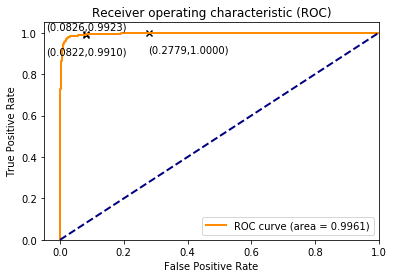

In [50]:
plt.figure()
lw = 2
plt.plot(fpr_2, tpr_2, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % auc_bad)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.scatter(fpr_2[-2],tpr_2[-2],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_2[-2],tpr_2[-2]), # this is the text
                 (fpr_2[-2],tpr_2[-2]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='left')# horizontal alignment can be left, right or center
plt.scatter(fpr_2[-14],tpr_2[-14],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_2[-14],tpr_2[-14]), # this is the text
                 (fpr_2[-14],tpr_2[-14]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center',) # horizontal alignment can be left, right or center
plt.scatter(fpr_2[-16],tpr_2[-16],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_2[-16],tpr_2[-16]), # this is the text
                 (fpr_2[-16],tpr_2[-16]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center',) # horizontal alignment can be left, right or center

plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('resnet_18_weighted_roc.jpg')
plt.show()

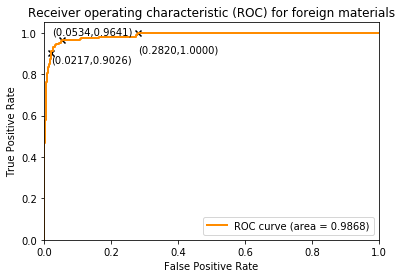

In [64]:
plt.figure()
lw = 2
plt.plot(fpr_fm,tpr_fm, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % auc_fm)
plt.scatter(fpr_fm[-2],tpr_fm[-2],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_fm[-2],tpr_fm[-2]), # this is the text
                 (fpr_fm[-2],tpr_fm[-2]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='left')# horizontal alignment can be left, right or center
plt.scatter(fpr_fm[-16],tpr_fm[-16],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_fm[-16],tpr_fm[-16]), # this is the text
                 (fpr_fm[-16],tpr_fm[-16]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-10,5), # distance from text to points (x,y)
                 ha='left',) # horizontal alignment can be left, right or center
plt.scatter(fpr_fm[-36],tpr_fm[-36],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_fm[-36],tpr_fm[-36]), # this is the text
                 (fpr_fm[-36],tpr_fm[-36]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-10), # distance from text to points (x,y)
                 ha='left')# horizontal alignment can be left, right or center

plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) for foreign materials')
plt.legend(loc="lower right")
plt.savefig('resnet_18_weighted_fm_roc.jpg')
plt.show()

# confusion matrix
cm = confusion_matrix(results.label.to_numpy(), results.prediction.to_numpy())
idx = [4,0,1,2,3,5,6,7,8,9]
cm = cm[:,idx]
cm = cm[idx,:]
print(cm.T)
plot_confusion_matrix(cm.T,range(10),[class_names[i] for i in idx])

[[ 766   12]
 [ 124 2928]]


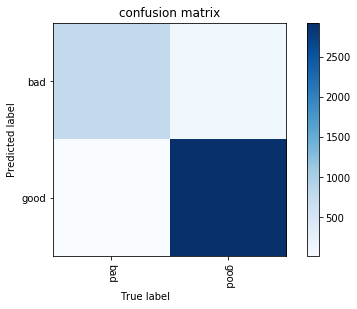

In [52]:
cm_2 = np.array([[cm[0,0], np.sum(cm[0,1:])],
                 [np.sum(cm[1:,0]), np.sum(cm[1:,1:])]])
idx_2 = [1,0]
cm_2 = cm_2[:,idx_2]
cm_2 = cm_2[idx_2,:]
print(cm_2)
plot_confusion_matrix(cm_2.T,[0,1],['bad', 'good'])

[[ 166   29]
 [  51 3584]]


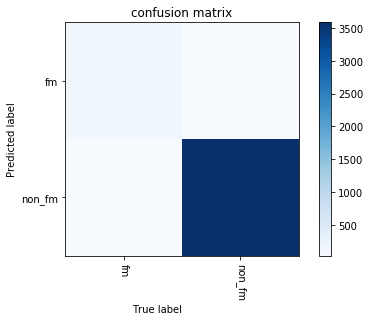

In [53]:
# confusion matrix fm
cm = confusion_matrix(results.label.to_numpy(), results.prediction.to_numpy())
idx = [3,0,1,2,4,5,6,7,8,9]
cm = cm[:,idx]
cm = cm[idx,:]
cm_2 = np.array([[cm[0,0], np.sum(cm[0,1:])],
                 [np.sum(cm[1:,0]), np.sum(cm[1:,1:])]])
print(cm_2)
plot_confusion_matrix(cm_2.T,[0,1],['fm', 'non_fm'])

In [39]:
results = pd.read_csv('test_result_resnet_18_weighted.csv')

In [41]:
results[(results['label']!=results['prediction']) & (results['prediction']=='good')].groupby(['prediction','label']).count()[['id']]

id
prediction label               
good       chipping           4
           device_flip        1
           foreign_material   2
           lead_defect        2
           lead_glue          1
           scratch            3

In [42]:
results[(results['label']!=results['prediction']) & (results['label']=='foreign_material')].groupby(['label','prediction']).count()[['id']]

id
label            prediction        
foreign_material chipping        12
                 device_flip      1
                 good             2
                 marking_defect   1
                 scratch         13

In [9]:
# test resnet_18
model_ft.eval()
results = pd.DataFrame(columns=['id','label'])

running_corrects = 0
running_TP = running_TN = running_FP = running_FN = 0
running_TP_fm = running_TN_fm = running_FP_fm = running_FN_fm = 0
running_f_fm = 0
y_true = []
y_pred = []

for i, ((inputs, labels), names) in enumerate(dataloaders, 0):
    inputs = inputs.to(device)
    labels = labels.to(device)

    # forward
    with torch.set_grad_enabled(False):
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
                
    running_corrects += torch.sum(preds == labels.data)
    
    TP, FP, TN, FN = perf_measure_bad(labels.data,preds)            
    running_TP += TP
    running_FP += FP
    running_TN += TN
    running_FN += FN
    
    TP_fm, FP_fm, TN_fm, FN_fm = perf_measure_fm(labels.data,preds)            
    running_TP_fm += TP_fm
    running_FP_fm += FP_fm
    running_TN_fm += TN_fm
    running_FN_fm += FN_fm

    f_fm = good_to_false_fm(labels.data,preds)
    running_f_fm += f_fm

    m = nn.Softmax(dim=1)
    probs = m(outputs)

    y_true.append(labels.data.cpu())
    y_pred.append(probs.cpu())
    
    result = pd.DataFrame({'id':names,'label':labels.detach().cpu(),'prediction':preds.detach().cpu()})
    for i, class_name in enumerate(class_names):
        result['{}_score'.format(class_name)] = probs.detach().cpu()[:,i]
    results = results.append(result)

acc = running_corrects.double() / dataset_sizes

if (running_TP+running_FN==0):
    TPR = float('nan')
else:
    TPR = running_TP / (running_TP + running_FN)
if (running_TN+running_FP==0):
    TNR = float('nan')
else:
    TNR = running_TN / (running_TN + running_FP)

if (running_TP_fm+running_FN_fm==0):
    TPR_fm = float('nan')
else:
    TPR_fm = running_TP_fm / (running_TP_fm + running_FN_fm)
if (running_TN_fm+running_FP_fm==0):
    TNR_fm = float('nan')
else:
    TNR_fm = running_TN_fm / (running_TN_fm + running_FP_fm)
            
if (running_FP==0):
    f_fm_rate = float('nan')
else:
    f_fm_rate = running_f_fm / running_FP

y_true = torch.cat(y_true)
y_pred = torch.cat(y_pred)
y_bad = y_true!=4
y_fm = y_true==3
y_bad_score = torch.cat((y_pred[:,:4],y_pred[:,5:]),1).sum(1)
y_fm_score = y_pred[:,3]
auc_bad = roc_auc_score(y_bad, y_bad_score,average='weighted')
auc_fm = roc_auc_score(y_fm, y_fm_score,average='weighted')
auc_ovr = roc_auc_score(y_true, y_pred,average='weighted',multi_class='ovr')
auc_ovo = roc_auc_score(y_true, y_pred,average='weighted',multi_class='ovo')
fpr, tpr, thresholds = roc_curve(y_bad, y_bad_score)

print('Test acc: {:.4f} TPR: {:.4f} TNR: {:.4f} TPR_fm: {:.4f} TNR_fm: {:.4f} fm/FP: {:.4f} AUC_bad: {:.4f} AUC_fm: {:.4f} AUC: {:.4f}'
      .format(acc, TPR, TNR, TPR_fm, TNR_fm, f_fm_rate, auc_bad, auc_fm, auc_ovr))

results['label'] = results['label'].apply(lambda i: class_names[i])
results['prediction'] = results['prediction'].astype('int').apply(lambda i: class_names[i])

results.to_csv('test_result_resnet_18.csv',index=False)

Test acc: 0.9666 TPR: 0.9589 TNR: 0.9934 TPR_fm: 0.8718 TNR_fm: 0.9904 fm/FP: 0.4000 AUC_bad: 0.9970 AUC_fm: 0.9922 AUC: 0.9959


In [28]:
torch.logical_and(y_true!=4, y_bad_score<=1.0417834e-02)

tensor([False, False, False,  ..., False, False, False])

In [15]:
suspected_good = np.array(results['id'])[torch.logical_and(y_true!=4, y_bad_score<=thresholds_bad[-16])]

In [16]:
suspected_bad = np.array(results['id'])[torch.logical_and(y_true==4, y_bad_score>thresholds_bad[-14])]

In [17]:
suspected_bad.shape

(143,)

In [64]:
len(np.nonzero(np.logical_and(y_true.numpy()==4, y_bad_score.numpy()>1.6341094e-02))[0])/len(np.nonzero(y_true==4))

0.05832241153342071

In [95]:
np.nonzero(np.logical_and(y_true.numpy()!=4, y_bad_score.numpy()<=1.6341094e-02))[0]

array([1134, 1291, 1304, 2230, 3059, 3387, 3663, 3671])

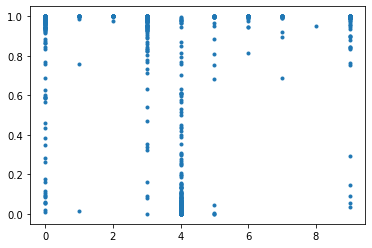

In [14]:
plt.plot(y_true, y_bad_score,'.');
# for i in np.nonzero(np.logical_and(y_true.numpy()!=4, y_bad_score.numpy()<=1.6341094e-02))[0]:
#     print(y_true.numpy()[i],y_bad_score.numpy()[i])
#     plt.annotate('({:d},{:.4f})'.format(y_true[i],y_bad_score[i]), # this is the text
#                  (y_true[i],y_bad_score[i]), # this is the point to label
#                  textcoords="offset points", # how to position the text
#                  xytext=(0,-20), # distance from text to points (x,y)
#                  ha='left')# horizontal alignment can be left, right or center

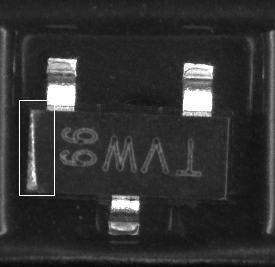

In [36]:
im = Image.open("/home/kaiyihuang/nexperia/new_data/test/chipping/WEP93807152A_16-APG_ITIS_H115_2_561_4.bmp")

# create rectangle image 
img1 = ImageDraw.Draw(im)   
img1.rectangle([(19,100),(54,195)], outline ="white") 
display(im)

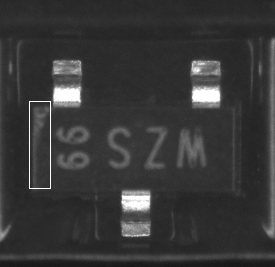

In [37]:
im = Image.open("/home/kaiyihuang/nexperia/new_data/test/chipping/WEP93739410A_06-APG_ITIS_H53_1_805_3.bmp")

# create rectangle image 
img1 = ImageDraw.Draw(im)   
img1.rectangle([(29,101),(50,188)], outline ="white") 
display(im)

In [ ]:
im = Image.open("/home/kaiyihuang/nexperia/new_data/test/chipping/WEP93739410A_06-APG_ITIS_H53_1_805_3.bmp")

# create rectangle image 
img1 = ImageDraw.Draw(im)   
img1.rectangle([(29,101),(50,188)], outline ="white") 
display(im)

In [49]:
torch.logical_and(y_true==4, y_bad_score>thresholds_bad[-14])[100:110]

tensor([False, False, False, False, False, False, False, False, False, False])

In [51]:
y_pred[torch.logical_and(y_true!=4, y_bad_score<=thresholds_bad[-16]),:]

tensor([[6.9872e-04, 1.8449e-04, 2.1687e-05, 2.3488e-02, 9.6583e-01, 6.7821e-03,
         1.2557e-03, 4.3087e-04, 4.2996e-05, 1.2686e-03],
        [2.4619e-03, 2.4236e-04, 3.0121e-05, 2.2432e-04, 9.9221e-01, 4.1434e-03,
         3.5761e-04, 1.4401e-04, 2.7576e-05, 1.6259e-04],
        [1.8844e-04, 4.3666e-06, 7.9822e-07, 4.7903e-05, 9.9945e-01, 2.8235e-04,
         6.9316e-06, 1.6867e-06, 1.0208e-06, 1.4649e-05],
        [2.4344e-04, 1.6542e-06, 1.0215e-07, 3.0827e-04, 9.9920e-01, 5.1158e-05,
         2.2917e-05, 2.4991e-06, 9.2237e-07, 1.7093e-04],
        [1.1057e-06, 1.2982e-09, 2.2974e-10, 2.6949e-05, 9.9997e-01, 1.8180e-07,
         1.6529e-08, 1.2662e-09, 3.6591e-09, 9.9852e-07],
        [1.5801e-05, 1.1831e-05, 5.6296e-07, 2.4799e-04, 9.9674e-01, 2.8047e-03,
         1.4869e-04, 8.4469e-06, 8.9480e-07, 2.5606e-05],
        [5.6938e-03, 3.0923e-06, 3.0755e-06, 6.6066e-03, 9.8429e-01, 9.4402e-05,
         3.8453e-05, 4.1076e-05, 1.4921e-05, 3.2159e-03],
        [1.1779e-02, 1.8857

In [50]:
y_pred[torch.logical_and(y_true==4, y_bad_score>thresholds_bad[-14]),:][100:110,:]

tensor([[8.0845e-04, 2.7430e-05, 7.2802e-06, 1.5610e-02, 9.8050e-01, 1.2186e-03,
         8.1682e-05, 2.2764e-04, 1.4767e-05, 1.5032e-03],
        [3.7844e-03, 2.6763e-04, 1.2046e-04, 2.5196e-03, 9.7647e-01, 1.2084e-02,
         4.6532e-04, 1.7803e-04, 5.6636e-05, 4.0547e-03],
        [2.6147e-02, 1.0725e-05, 3.0856e-06, 3.5439e-04, 9.7265e-01, 1.7903e-04,
         3.5030e-05, 1.4330e-05, 8.9890e-06, 5.9766e-04],
        [5.5392e-04, 9.1162e-05, 4.7083e-06, 4.4764e-01, 5.4954e-01, 3.6345e-04,
         4.1189e-04, 6.0900e-05, 1.1692e-05, 1.3257e-03],
        [3.3259e-02, 5.9164e-05, 1.9617e-05, 1.6924e-02, 9.4564e-01, 8.2765e-04,
         9.0187e-04, 4.8879e-04, 5.1170e-05, 1.8274e-03],
        [5.6476e-03, 2.0621e-04, 3.7531e-05, 5.7771e-03, 9.8041e-01, 3.6955e-03,
         1.0681e-03, 4.9538e-04, 7.4593e-05, 2.5877e-03],
        [9.6145e-01, 7.5194e-05, 9.4064e-06, 4.9741e-03, 2.6018e-02, 1.3175e-04,
         1.0903e-04, 2.1204e-05, 8.9221e-05, 7.1189e-03],
        [1.4118e-02, 3.5893

/home/kaiyihuang/nexperia/new_data/test/good/WEL91128011A_01-W20-ITISA09-1_51_1.bmp
/home/kaiyihuang/nexperia/new_data/test/good/WEL93733816A_01-W1A-ITISA54-1_319_1.bmp
/home/kaiyihuang/nexperia/new_data/test/good/WEE93800522A_01-W1A-ITISA45-2_194_1.bmp
/home/kaiyihuang/nexperia/new_data/test/good/WEP93705970A_19-210-ITISA75-1_120_2.bmp
/home/kaiyihuang/nexperia/new_data/test/good/WEP938028K1A_01-W1A-ITISA47-1_305_4.bmp
/home/kaiyihuang/nexperia/new_data/test/good/WEP931428Q5A_14-WR6-ITISA20-2_152_2.bmp
/home/kaiyihuang/nexperia/new_data/test/good/WEP938002H1B_26-A7W-ITISA45-1_176_2.bmp
/home/kaiyihuang/nexperia/new_data/test/good/WEP93724593A_12-5CW-ITISA73-2_234_2.bmp
/home/kaiyihuang/nexperia/new_data/test/good/WEP93705831A_10-110-ITISA57-1_67_2.bmp
/home/kaiyihuang/nexperia/new_data/test/good/WEL93514258A_10-1FW-ITISA13-1_74_1.bmp


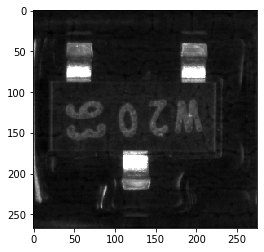

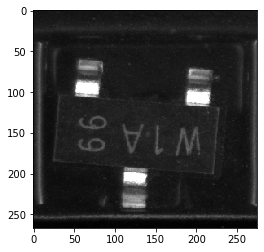

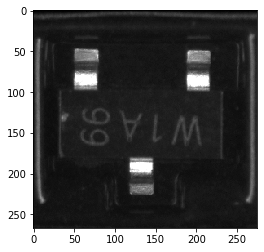

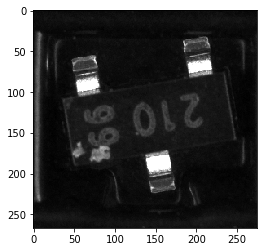

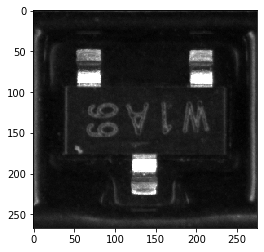

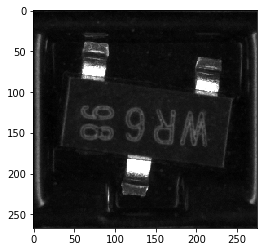

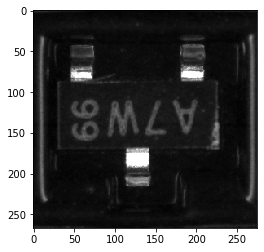

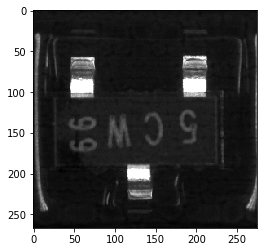

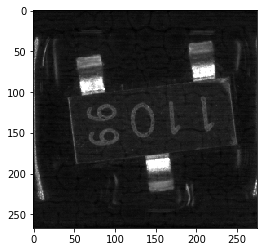

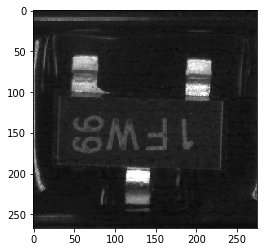

In [40]:
for file in suspected_bad[100:110]:
    process(file)

/home/kaiyihuang/nexperia/new_data/test/scratch/WEP938425D5A_01-APG_ITIS_H52_2_397_2.bmp
/home/kaiyihuang/nexperia/new_data/test/chipping/WEP93807152A_16-APG_ITIS_H115_2_561_4.bmp
/home/kaiyihuang/nexperia/new_data/test/lead_defect/WEP93803811A_44-APG_ITIS_H73_2_72_1.bmp
/home/kaiyihuang/nexperia/new_data/test/lead_defect/WEL93514258A_55-APG_ITIS_H09_1_67_3.bmp
/home/kaiyihuang/nexperia/new_data/test/foreign_material/WEP93713712A_12-APG_ITIS_H43_2_278_3.bmp
/home/kaiyihuang/nexperia/new_data/test/lead_defect/WEP93724782A_01-APG_ITIS_H57_2_17_1.bmp
/home/kaiyihuang/nexperia/new_data/test/device_flip/WEP93509812A_21-APG_ITIS_H49_1_214_2.bmp
/home/kaiyihuang/nexperia/new_data/test/chipping/WEP93739410A_06-APG_ITIS_H53_1_805_3.bmp


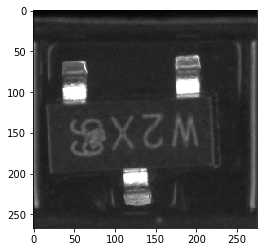

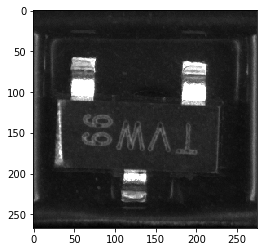

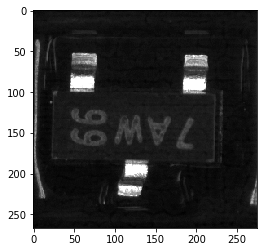

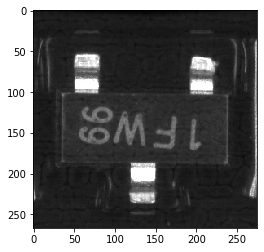

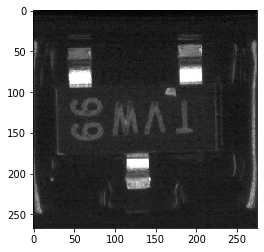

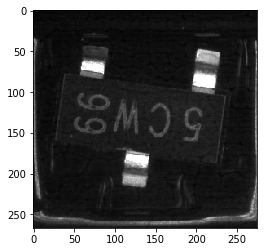

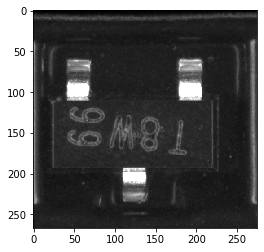

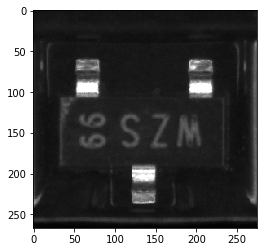

In [33]:
for file in suspected_good:
    process(file)

/home/kaiyihuang/nexperia/new_data/test/good/WEE93800542A_04-W1A-ITISA46-1_237_3.bmp
/home/kaiyihuang/nexperia/new_data/test/good/WEL930041D5A_05-WV3-ITISA13-1_329_1.bmp
/home/kaiyihuang/nexperia/new_data/test/good/WEP937297M2A_21-W1A-ITISA50-1_63_2.bmp
/home/kaiyihuang/nexperia/new_data/test/good/WEP93734592A_21-W1P-ITISA47-1_131_3.bmp
/home/kaiyihuang/nexperia/new_data/test/good/WEP93617044A_16-1GW-ITISA44-1_48_3.bmp


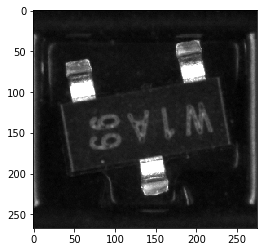

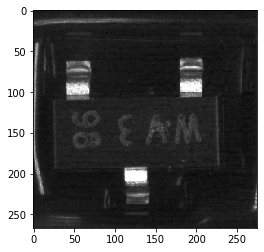

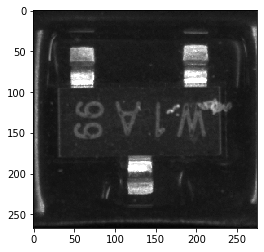

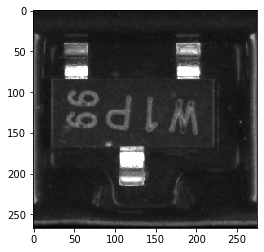

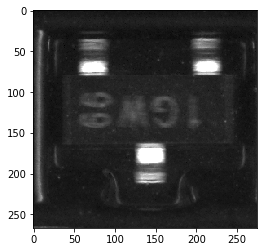

In [31]:
def process(filename: str=None) -> None:
    """
    View multiple images stored in files, stacking vertically

    Arguments:
        filename: str - path to filename containing image
    """
    image = mpimg.imread(filename)
    # <something gets done here>
    plt.figure()
    plt.imshow(image,cmap='gray')
    print(filename)

for file in suspected_bad[160:]:
    process(file)

In [11]:
fpr_bad, tpr_bad, thresholds_bad = roc_curve(y_bad, y_bad_score)

In [12]:
tpr_bad

array([0.        , 0.00128535, 0.01413882, 0.01670951, 0.01799486,
       0.02056555, 0.02956298, 0.03213368, 0.0437018 , 0.04627249,
       0.21465296, 0.21465296, 0.25578406, 0.25835476, 0.34061697,
       0.34318766, 0.45244216, 0.45501285, 0.52570694, 0.52827763,
       0.75064267, 0.75064267, 0.76478149, 0.76478149, 0.76992288,
       0.76992288, 0.79434447, 0.79434447, 0.81105398, 0.81105398,
       0.83676093, 0.83676093, 0.85861183, 0.85861183, 0.88174807,
       0.88174807, 0.89460154, 0.89460154, 0.90488432, 0.90488432,
       0.91773779, 0.91773779, 0.92159383, 0.92159383, 0.92802057,
       0.92802057, 0.9344473 , 0.9344473 , 0.94601542, 0.94601542,
       0.94730077, 0.94730077, 0.95244216, 0.95244216, 0.96015424,
       0.96015424, 0.96272494, 0.96272494, 0.96401028, 0.96401028,
       0.96529563, 0.96529563, 0.96786632, 0.96786632, 0.96915167,
       0.96915167, 0.97043702, 0.97043702, 0.97172237, 0.97172237,
       0.97557841, 0.97557841, 0.97686375, 0.97686375, 0.97814

In [13]:
fpr_bad

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.27653997e-04,
       3.27653997e-04, 3.27653997e-04, 3.27653997e-04, 3.27653997e-04,
       3.27653997e-04, 3.27653997e-04, 3.27653997e-04, 3.27653997e-04,
       3.27653997e-04, 9.82961992e-04, 9.82961992e-04, 1.31061599e-03,
       1.31061599e-03, 1.63826999e-03, 1.63826999e-03, 1.96592398e-03,
       1.96592398e-03, 2.29357798e-03, 2.29357798e-03, 2.62123198e-03,
       2.62123198e-03, 2.94888598e-03, 2.94888598e-03, 3.27653997e-03,
       3.27653997e-03, 3.60419397e-03, 3.60419397e-03, 3.93184797e-03,
       3.93184797e-03, 4.25950197e-03, 4.25950197e-03, 4.58715596e-03,
       4.58715596e-03, 4.91480996e-03, 4.91480996e-03, 5.24246396e-03,
       5.24246396e-03, 5.57011796e-03, 5.57011796e-03, 5.89777195e-03,
       5.89777195e-03, 6.22542595e-03, 6.22542595e-03, 6.88073394e-03,
      

In [14]:
thresholds_bad

array([1.9999993e+00, 9.9999934e-01, 9.9999684e-01, 9.9999487e-01,
       9.9999470e-01, 9.9999374e-01, 9.9998885e-01, 9.9998838e-01,
       9.9998081e-01, 9.9997967e-01, 9.9974000e-01, 9.9973494e-01,
       9.9963695e-01, 9.9962705e-01, 9.9930626e-01, 9.9928927e-01,
       9.9853110e-01, 9.9851882e-01, 9.9772984e-01, 9.9764562e-01,
       9.8723775e-01, 9.8691905e-01, 9.8482758e-01, 9.8471940e-01,
       9.8423475e-01, 9.8418117e-01, 9.7936386e-01, 9.7912288e-01,
       9.7447538e-01, 9.7431177e-01, 9.6559405e-01, 9.6528649e-01,
       9.5039034e-01, 9.4949681e-01, 9.3137062e-01, 9.2651367e-01,
       8.9259303e-01, 8.9011228e-01, 8.7254691e-01, 8.6607146e-01,
       8.2788360e-01, 8.2336551e-01, 7.9983038e-01, 7.9832566e-01,
       7.6106113e-01, 7.5669426e-01, 7.3181534e-01, 7.2613716e-01,
       7.0103866e-01, 6.9910866e-01, 6.9850498e-01, 6.9830251e-01,
       6.5953451e-01, 6.4760864e-01, 5.8967066e-01, 5.7260579e-01,
       5.6495452e-01, 5.6335121e-01, 5.4905939e-01, 5.0218183e

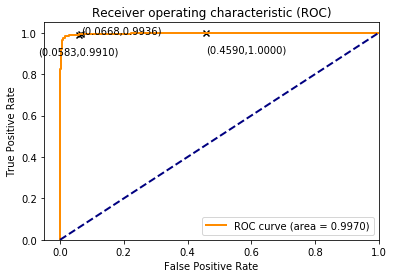

In [20]:
fpr, tpr, thresholds = roc_curve(y_bad, y_bad_score)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % auc_bad)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.scatter(fpr[-2],tpr[-2],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr[-2],tpr[-2]), # this is the text
                 (fpr[-2],tpr[-2]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='left')# horizontal alignment can be left, right or center
plt.scatter(fpr[-12],tpr[-12],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr[-12],tpr[-12]), # this is the text
                 (fpr[-12],tpr[-12]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,0), # distance from text to points (x,y)
                 ha='left',) # horizontal alignment can be left, right or center
plt.scatter(fpr[-16],tpr[-16],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr[-16],tpr[-16]), # this is the text
                 (fpr[-16],tpr[-16]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center',) # horizontal alignment can be left, right or center

plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('resnet_18_roc.jpg')
plt.show()

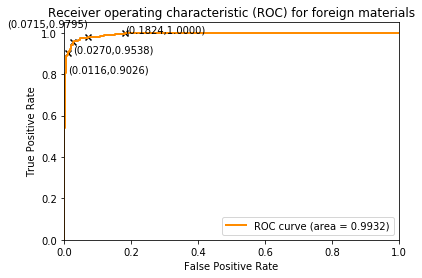

In [36]:
plt.figure()
lw = 2
plt.plot(fpr_fm,tpr_fm, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % auc_fm)
plt.scatter(fpr_fm[-2],tpr_fm[-2],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_fm[-2],tpr_fm[-2]), # this is the text
                 (fpr_fm[-2],tpr_fm[-2]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,0), # distance from text to points (x,y)
                 ha='left')# horizontal alignment can be left, right or center
plt.scatter(fpr_fm[-10],tpr_fm[-10],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_fm[-10],tpr_fm[-10]), # this is the text
                 (fpr_fm[-10],tpr_fm[-10]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='right',) # horizontal alignment can be left, right or center
plt.scatter(fpr_fm[-20],tpr_fm[-20],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_fm[-20],tpr_fm[-20]), # this is the text
                 (fpr_fm[-20],tpr_fm[-20]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-10), # distance from text to points (x,y)
                 ha='left')# horizontal alignment can be left, right or center
plt.scatter(fpr_fm[-38],tpr_fm[-38],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_fm[-38],tpr_fm[-38]), # this is the text
                 (fpr_fm[-38],tpr_fm[-38]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='left')# horizontal alignment can be left, right or center

plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) for foreign materials')
plt.legend(loc="lower right")
plt.savefig('resnet_18_fm_roc.jpg')
plt.show()

[[3033    9    1    0    6    3    0    2    0    6]
 [  11  349    1    0   11    2    0    1    0   24]
 [   0    0   12    0    0    1    0    0    0    0]
 [   0    0    0   20    0    0    0    0    0    0]
 [   5    2    0    0  174    1    0    0    1   16]
 [   0    0    0    0    0   17    0    0    0    0]
 [   0    0    0    0    0    1   62    0    0    0]
 [   0    0    0    0    0    0    0   15    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   3    8    0    0    4    0    0    0    0   29]]


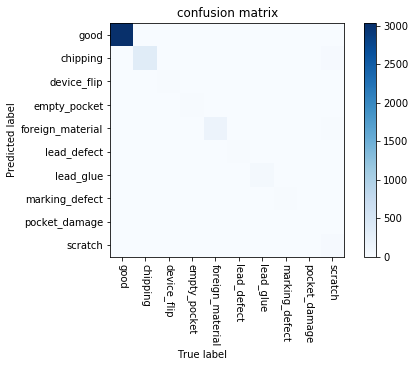

In [23]:
# confusion matrix
cm = confusion_matrix(results.label.to_numpy(), results.prediction.to_numpy())
idx = [4,0,1,2,3,5,6,7,8,9]
cm = cm[:,idx]
cm = cm[idx,:]
print(cm.T)
plot_confusion_matrix(cm.T,range(10),[class_names[i] for i in [4,0,1,2,3,5,6,7,8,9]])

[[ 751   27]
 [  19 3033]]


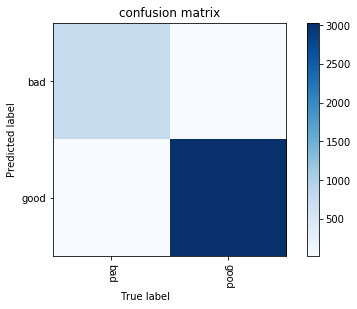

In [24]:
cm_2 = np.array([[cm[0,0], np.sum(cm[0,1:])],
                 [np.sum(cm[1:,0]), np.sum(cm[1:,1:])]])
idx_2 = [1,0]
cm_2 = cm_2[:,idx_2]
cm_2 = cm_2[idx_2,:]
print(cm_2)
plot_confusion_matrix(cm_2.T,[0,1],['bad', 'good'])

[[ 174   21]
 [  25 3610]]


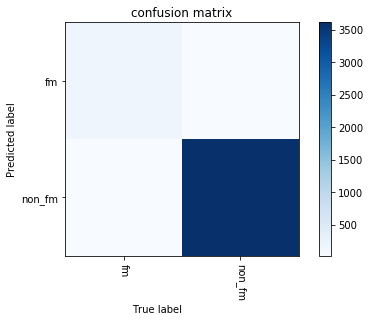

In [25]:
# confusion matrix fm
cm = confusion_matrix(results.label.to_numpy(), results.prediction.to_numpy())
idx = [3,0,1,2,4,5,6,7,8,9]
cm = cm[:,idx]
cm = cm[idx,:]
cm_2 = np.array([[cm[0,0], np.sum(cm[0,1:])],
                 [np.sum(cm[1:,0]), np.sum(cm[1:,1:])]])
print(cm_2)
plot_confusion_matrix(cm_2.T,[0,1],['fm', 'non_fm'])

In [91]:
[class_names[i]]

['chipping']

In [60]:
image_datasets.class_to_idx

{'chipping': 0,
 'device_flip': 1,
 'empty_pocket': 2,
 'foreign_material': 3,
 'good': 4,
 'lead_defect': 5,
 'lead_glue': 6,
 'marking_defect': 7,
 'pocket_damage': 8,
 'scratch': 9}

In [22]:
results[(results['label']!=results['prediction']) & (results['prediction']=='good')].groupby(['prediction','label']).count()[['id']]

id
prediction label               
good       chipping          10
           device_flip        1
           foreign_material   5
           lead_defect        5
           marking_defect     1
           scratch            6

In [354]:
results[(results['label']!=results['prediction']) & (results['label']=='good')].groupby(['label','prediction']).count()[['id']]

id
label prediction          
good  chipping          13
      foreign_material   5
      scratch            1

In [360]:
for i in results[(results['label']!=results['prediction']) & (results['label']=='good')]['id']:
    print(i)
    print(results[results['id']==i]['prediction'])

/home/kaiyihuang/nexperia/new_data/test/good/WEP937405K1A_01-Z7W-ITISA45-2_369_1.bmp
10    foreign_material
Name: prediction, dtype: object
/home/kaiyihuang/nexperia/new_data/test/good/WEP937023H4A_11-A4W-ITISA47-1_65_2.bmp
2    chipping
Name: prediction, dtype: object
/home/kaiyihuang/nexperia/new_data/test/good/WEL927267D5A_21-WCM-ITISA53-2_25_3.bmp
3    chipping
Name: prediction, dtype: object
/home/kaiyihuang/nexperia/new_data/test/good/WEE93900190A_14-1FW-ITISA44-2_163_2.bmp
16    chipping
Name: prediction, dtype: object
/home/kaiyihuang/nexperia/new_data/test/good/WEL93728915A_46-6BW-ITISA54-1_90_2.bmp
4    chipping
Name: prediction, dtype: object
/home/kaiyihuang/nexperia/new_data/test/good/WEP93714351A_09-TVW-ITISA43-2_384_1.bmp
26    chipping
Name: prediction, dtype: object
/home/kaiyihuang/nexperia/new_data/test/good/WEP937154U3A_06-A7W-ITISA45-2_287_4.bmp
6    chipping
Name: prediction, dtype: object
/home/kaiyihuang/nexperia/new_data/test/good/WEP936218H4A_05-3GW-ITISA49-1_

In [23]:
results[(results['label']!=results['prediction']) & (results['label']=='foreign_material')].groupby(['label','prediction']).count()[['id']]

id
label            prediction    
foreign_material chipping    14
                 good         5
                 scratch      7

In [49]:
results[(results['label']!=results['prediction']) & (results['prediction']==4)].groupby(['label']).count()

,id,prediction
label,,
0,16,16
1,1,1
3,11,11
5,6,6
9,3,3


In [52]:
results[results['label']!=results['prediction']].groupby(['prediction','label']).count()

id
prediction label    
0.0        3       8
           4      12
           5       3
           9      21
1.0        5       1
3.0        0       3
           4       8
           5       1
           6       1
           8       1
           9      19
4.0        0      16
           1       1
           3      11
           5       6
           9       3
5.0        1       2
9.0        0      12
           3       7

In [274]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [288]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, ((inputs, labels), names) in enumerate(dataloaders):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                if preds[j]!=labels.data[j] and preds[j]==4:
                    images_so_far += 1
                    ax = plt.subplot(1, num_images, images_so_far)
                    ax.axis('off')
                    ax.set_title('predicted: {}, actual: {}'.format(class_names[preds[j]],class_names[labels[j]]))
                    imshow(inputs.cpu().data[j])

                    if images_so_far == num_images:
                        model.train(mode=was_training)
                        return
        model.train(mode=was_training)

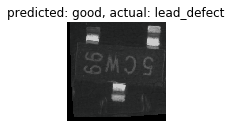

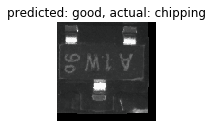

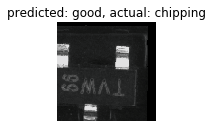

In [289]:
# FP
visualize_model(model_ft,3)

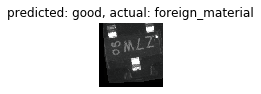

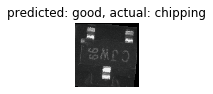

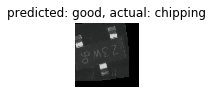

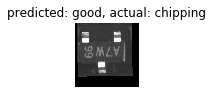

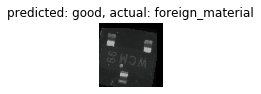

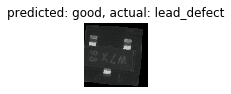

In [29]:
# FP
visualize_model(model_ft)

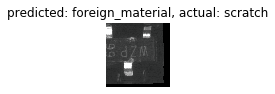

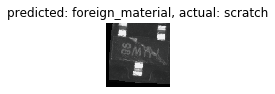

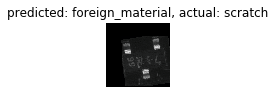

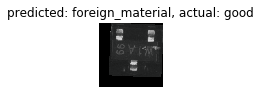

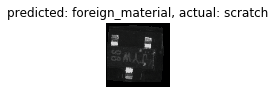

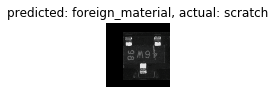

In [32]:
# FN foreign material
visualize_model(model_ft)

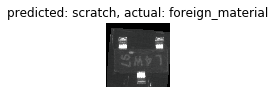

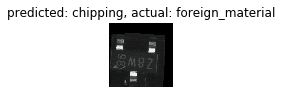

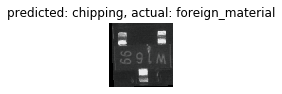

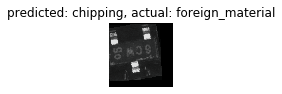

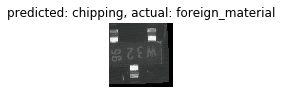

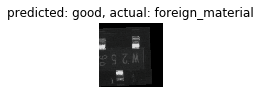

In [34]:
# FP foreign material
visualize_model(model_ft)

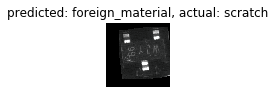

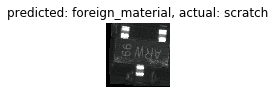

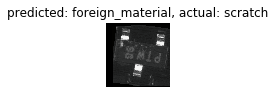

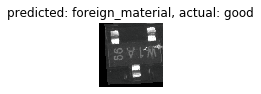

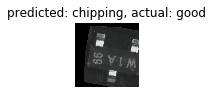

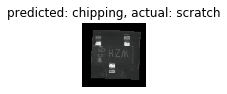

In [36]:
# bad predictions
visualize_model(model_ft)

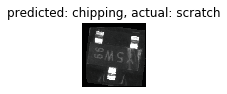

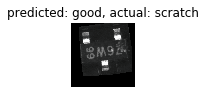

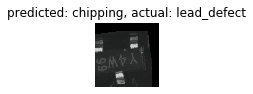

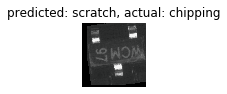

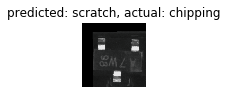

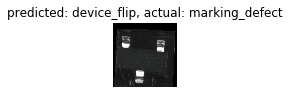

In [37]:
visualize_model(model_ft)

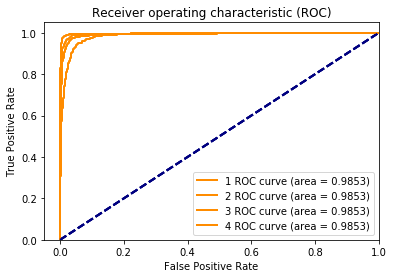

In [341]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='1 ROC curve (area = %0.4f)' % auc_bad)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.plot(fpr_2, tpr_2, color='darkorange',
         lw=lw, label='2 ROC curve (area = %0.4f)' % auc_bad)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.plot(fpr_3, tpr_3, color='darkorange',
         lw=lw, label='3 ROC curve (area = %0.4f)' % auc_bad)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.plot(fpr_4, tpr_4, color='darkorange',
         lw=lw, label='4 ROC curve (area = %0.4f)' % auc_bad)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('roc.jpg')
plt.show()